# 클로드 버전 13에 수정 한 코드 
네, 맞습니다. 모든 결과는 **체계적으로 폴더에 정리되어 저장**됩니다:

## 폴더 구조:

### `./trained_model_v5/` (학습된 모델들)
```
trained_model_v5/
├── nanji_CatBoost_Reg_regression_20250827_185516.pkl
├── nanji_XGBoost_Clf_classification_20250827_185519.pkl  
├── jungnang_CatBoost_Reg_regression_20250827_185612.pkl
├── jungnang_XGBoost_Clf_classification_20250827_185615.pkl
├── (각 센터별 최고 성능 모델들...)
└── training_summary.csv (학습 요약)
```

### `./results_v5/` (분석 결과들)
```
results_v5/
├── feature_importance_nanji_CatBoost_Reg_regression_20250827_185516.png
├── shap_bar_nanji_CatBoost_Reg_regression_20250827_185516.png
├── shap_beeswarm_nanji_CatBoost_Reg_regression_20250827_185516.png
├── shap_summary_nanji_CatBoost_Reg_regression_20250827_185516.csv
├── (센터별 SHAP & 피처 중요도 파일들...)
├── regression_performance_comparison_20250827_185802.png
├── classification_performance_comparison_20250827_185802.png  
├── model_performance_comparison_20250827_185802.png
├── best_performance_summary_20250827_185802.png
└── predictions_20250827_193045.csv (예측 결과, 나중에)
```

## 자동 폴더 생성:
```python
os.makedirs(save_dir, exist_ok=True)        # ./trained_model_v5/
os.makedirs(results_dir, exist_ok=True)     # ./results_v5/  
```

**절대 파일들이 띡띢띡 흩어져 저장되지 않습니다.** 

- **모델 파일들**: 한 곳에 모음
- **분석 그래프들**: 한 곳에 모음  
- **타임스탬프로 버전 관리**: 덮어쓰기 방지

폴더가 없으면 자동으로 만들어지고, 모든 파일은 용도별로 깔끔하게 정리됩니다.

In [1]:
# 필수 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score
from tqdm import tqdm
import time, os, json, warnings
import joblib
import pickle
from datetime import datetime
import gc

# 선택적 라이브러리 import
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGB = True
except ImportError:
    HAS_LGB = False

try:
    import catboost as cb
    HAS_CATBOOST = True
except ImportError:
    HAS_CATBOOST = False

try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False

# 한글 폰트 설정
warnings.filterwarnings("ignore")
try:
    plt.rcParams['font.family'] = 'AppleGothic' # 맥
except Exception:
    plt.rcParams['font.family'] ='Malgun Gothic' # 윈도우
plt.rcParams['axes.unicode_minus'] = False

print("="*80)
print("하수처리장 예측 파이프라인 초기화 완료")
print(f"XGBoost: {'✓' if HAS_XGB else '✗'}")
print(f"LightGBM: {'✓' if HAS_LGB else '✗'}")
print(f"CatBoost: {'✓' if HAS_CATBOOST else '✗'}")
print(f"SHAP: {'✓' if HAS_SHAP else '✗'}")
print("="*80)

# 각 SHAP 분석 후 메모리 정리
import gc
plt.close('all')  # 모든 matplotlib 그래프 닫기
gc.collect()      # 가비지 컬렉션 강제 실행

하수처리장 예측 파이프라인 초기화 완료
XGBoost: ✓
LightGBM: ✓
CatBoost: ✓
SHAP: ✓


0

In [2]:
# ================================================================================================
# 완전한 하수처리장 예측 파이프라인 (학습-저장-예측)
# ================================================================================================

# ================================================================================================
# 1. 모델 정의 함수들
# ================================================================================================
def build_regression_models():
    """회귀 모델들"""
    models = {}
    models["RandomForest_Reg"] = RandomForestRegressor(
        n_estimators=300, min_samples_leaf=2, random_state=42, n_jobs=-1
    )
    models["LinearRegression"] = LinearRegression()
    models["GradientBoosting_Reg"] = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, random_state=42
    )
    if HAS_XGB:
        models["XGBoost_Reg"] = xgb.XGBRegressor(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbosity=0
        )
    if HAS_LGB:
        models["LightGBM_Reg"] = lgb.LGBMRegressor(
            n_estimators=500, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbosity=-1
        )
    if HAS_CATBOOST:
        models["CatBoost_Reg"] = cb.CatBoostRegressor(
            iterations=500, learning_rate=0.05, depth=6,
            random_state=42, verbose=False
        )
    return models

def build_classification_models():
    """분류 모델들 (4등급)"""
    models = {}
    models["RandomForest_Clf"] = RandomForestClassifier(
        n_estimators=300, min_samples_leaf=2, random_state=42, 
        n_jobs=-1, class_weight='balanced'
    ) 
    models["GradientBoosting_Clf"] = GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, random_state=42
    )
    models["LogisticRegression_Clf"] = LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=1000,
        random_state=42, class_weight='balanced'
    )
    if HAS_XGB:
        models["XGBoost_Clf"] = xgb.XGBClassifier(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            objective="multi:softprob", num_class=4,
            tree_method="hist", random_state=42, n_jobs=-1, verbosity=0
        )
    if HAS_LGB:
        models["LightGBM_Clf"] = lgb.LGBMClassifier(
            n_estimators=500, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            objective="multiclass", num_class=4,
            random_state=42, n_jobs=-1, verbosity=-1, is_unbalance=True
        )
    if HAS_CATBOOST:
        models["CatBoost_Clf"] = cb.CatBoostClassifier(
            iterations=500, learning_rate=0.05, depth=6,
            random_state=42, verbose=False, auto_class_weights='Balanced'
        )
    return models

# ================================================================================================
# 2. 데이터 처리 함수들
# ================================================================================================
def make_pipeline_unified(model, model_name, model_type):
    """통합 전처리 파이프라인"""
    if model_name in ["LinearRegression", "LogisticRegression_Clf"]:
        pre = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ])
    else:
        pre = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ])
    return Pipeline(steps=[("pre", pre), ("model", model)])

def prepare_data_stratified(df, target_col, model_type, test_size=0.2, split_method='stratified'):
    """데이터 준비 - Stratified vs 시계열 분할"""
    work = df.sort_values('날짜').reset_index(drop=True).copy()
    dates = pd.to_datetime(work['날짜'])

    not_use_col = [
        '날짜',
        '1처리장','2처리장','정화조','중계펌프장','합계','시설현대화',
        '3처리장','4처리장','합계', '합계_1일후','합계_2일후',
        '등급','등급_1일후','등급_2일후'
    ]
    
    drop_cols = [c for c in (set(not_use_col) | {target_col}) if c in work.columns]
    X_raw = work.drop(columns=drop_cols, errors="ignore")
    
    for c in X_raw.columns:
        X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce")

    if model_type == "regression":
        y = pd.to_numeric(work[target_col], errors="coerce")
    else:
        y = work[target_col].astype("int64")

    valid_idx = (~X_raw.isnull().all(axis=1)) & (~pd.isnull(y))
    X_raw = X_raw[valid_idx].reset_index(drop=True)
    y = y[valid_idx].reset_index(drop=True)
    dates = dates[valid_idx].reset_index(drop=True)
    
    if split_method == 'stratified':
        if model_type == "classification":
            sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
            train_idx, test_idx = next(sss.split(X_raw, y))
        else:
            train_idx, test_idx = train_test_split(
                range(len(X_raw)), test_size=test_size, random_state=42
            )
            
        X_train, X_test = X_raw.iloc[train_idx].copy(), X_raw.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()
        dates_train, dates_test = dates.iloc[train_idx].copy(), dates.iloc[test_idx].copy()
        
    else:  # temporal split
        n = len(X_raw)
        split = int(n * (1 - test_size))
        X_train, X_test = X_raw.iloc[:split].copy(), X_raw.iloc[split:].copy()
        y_train, y_test = y.iloc[:split].copy(), y.iloc[split:].copy()
        dates_train, dates_test = dates.iloc[:split].copy(), dates.iloc[split:].copy()

    feature_names = list(X_raw.columns)
    return X_train, X_test, y_train, y_test, feature_names, dates_train, dates_test

def make_features(df, cutoff_date=None):
    """파생변수 생성 함수 - Data Leakage 방지 버전"""
    df = df.copy()
    
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜').reset_index(drop=True)
    
    # 디버깅 정보 - 시작 시점
    print(f"\n=== make_features 디버깅 ===")
    print(f"입력 데이터: {len(df)}행")
    print(f"날짜 범위: {df['날짜'].min()} ~ {df['날짜'].max()}")
    if cutoff_date is not None:
        cutoff = pd.to_datetime(cutoff_date)
        print(f"cutoff_date: {cutoff_date}")
        print(f"  cutoff 이전 데이터: {len(df[df['날짜'] <= cutoff])}행")
        print(f"  cutoff 이후 데이터: {len(df[df['날짜'] > cutoff])}행")

    df['월'] = df['날짜'].dt.month
    df['요일'] = df['날짜'].dt.weekday

    season_map = {'봄': 0, '여름': 1, '가을': 2, '겨울': 3}
    discomfort_map = {'쾌적': 0, '약간 불쾌': 1, '불쾌': 2, '매우 불쾌': 3, '극심한 불쾌': 4}
    df['계절'] = df['계절'].map(season_map).astype('Int64')
    df['불쾌지수등급'] = df['불쾌지수등급'].map(discomfort_map).astype('Int64')

    # 강수량 시차 피처
    df['강수량_1일전'] = df['일_일강수량(mm)'].shift(1)
    df['강수량_2일전'] = df['일_일강수량(mm)'].shift(2)
    df['강수량_1일_누적'] = df['일_일강수량(mm)'].rolling(1, min_periods=1).sum()
    df['강수량_2일_누적'] = df['일_일강수량(mm)'].rolling(2, min_periods=1).sum()
    df['강수량_3일_누적'] = df['일_일강수량(mm)'].rolling(3, min_periods=1).sum()
    df['강수량_5일_누적'] = df['일_일강수량(mm)'].rolling(5, min_periods=1).sum()
    df['강수량_7일_누적'] = df['일_일강수량(mm)'].rolling(7, min_periods=1).sum()

    df['일교차'] = df['일_최고기온(°C)'] - df['일_최저기온(°C)']
    df['폭우_여부'] = (df['일_일강수량(mm)'] >= 80).astype(int)
    
    # 체감온도 계산 (간단 버전)
    T = pd.to_numeric(df.get('일_평균기온(°C)', np.nan), errors='coerce')
    V_ms = pd.to_numeric(df.get('일_평균풍속(m/s)', np.nan), errors='coerce')
    RH = pd.to_numeric(df.get('평균습도(%)', np.nan), errors='coerce')
    
    e = (RH/100.0) * 6.105 * np.exp(17.27*T/(237.7 + T))
    df['체감온도(°C)'] = T + 0.33*e - 0.70*V_ms - 4.00
    
    # 분류용 등급 계산
    q = df['합계'].dropna().quantile([0.15, 0.70, 0.90])
    q15, q70, q90 = float(q.loc[0.15]), float(q.loc[0.70]), float(q.loc[0.90])
    print(f"등급 구분 기준: q15={q15:.0f}, q70={q70:.0f}, q90={q90:.0f}")

    def categorize(x):
        if pd.isna(x):
            return np.nan
        if x < q15:
            return 0
        elif x < q70:
            return 1
        elif x < q90:
            return 2
        else:
            return 3

    df['등급'] = df['합계'].apply(categorize)
    
    # 타겟 변수 생성 (Data Leakage 방지)
    if cutoff_date is not None:
        cutoff = pd.to_datetime(cutoff_date)
        print(f"타겟 변수 생성 (cutoff 적용)")
        
        df['합계_1일후'] = np.nan
        df['합계_2일후'] = np.nan
        df['등급_1일후'] = np.nan
        df['등급_2일후'] = np.nan
        
        # 생성된 타겟 개수 추적
        target_1day_count = 0
        target_2day_count = 0
        
        for i in range(len(df)):
            current_date = df.loc[i, '날짜']
            
            if i + 1 < len(df) and current_date <= cutoff:
                next_date = df.loc[i+1, '날짜']
                if next_date <= cutoff:
                    df.loc[i, '합계_1일후'] = df.loc[i+1, '합계']
                    df.loc[i, '등급_1일후'] = df.loc[i+1, '등급']
                    target_1day_count += 1
            
            if i + 2 < len(df) and current_date <= cutoff:
                next2_date = df.loc[i+2, '날짜']
                if next2_date <= cutoff:
                    df.loc[i, '합계_2일후'] = df.loc[i+2, '합계']
                    df.loc[i, '등급_2일후'] = df.loc[i+2, '등급']
                    target_2day_count += 1
                    
        print(f"  1일후 타겟 생성: {target_1day_count}개")
        print(f"  2일후 타겟 생성: {target_2day_count}개")
        
    else:
        print(f"타겟 변수 생성 (shift 사용)")
        df['합계_1일후'] = df['합계'].shift(-1)
        df['합계_2일후'] = df['합계'].shift(-2)
        df['등급_1일후'] = df['등급'].shift(-1).astype('Int64')
        df['등급_2일후'] = df['등급'].shift(-2).astype('Int64')
        print(f"  1일후 타겟 유효값: {df['합계_1일후'].notna().sum()}개")
        print(f"  2일후 타겟 유효값: {df['합계_2일후'].notna().sum()}개")

    df.attrs['cutoffs'] = {"q15": q15, "q70": q70, "q90": q90}
    
    # dropna 전후 비교
    before_dropna = len(df)
    df = df.dropna().reset_index(drop=True)
    after_dropna = len(df)
    print(f"dropna 처리: {before_dropna}행 → {after_dropna}행 ({before_dropna - after_dropna}행 제거)")
    
    # 2025-06-01 필터링
    before_filter = len(df)
    df = df[df["날짜"] < "2025-06-01"]
    after_filter = len(df)
    print(f"날짜 필터링: {before_filter}행 → {after_filter}행 ({before_filter - after_filter}행 제거)")
    
    # 최종 결과
    if '등급_1일후' in df.columns:
        final_grade_dist = df['등급_1일후'].value_counts().sort_index()
        print(f"최종 등급 분포: {dict(final_grade_dist)}")
    
    print(f"최종 출력: {len(df)}행, {len(df.columns)}컬럼")
    print(f"최종 날짜 범위: {df['날짜'].min()} ~ {df['날짜'].max()}")
    print(f"=== make_features 완료 ===\n")
    
    return df

def make_features_for_prediction(historical_df, future_df):
    """새로운 데이터에 대한 파생변수 생성 (과거 데이터 활용)"""
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df['날짜'] = pd.to_datetime(combined_df['날짜'])
    combined_df = combined_df.sort_values('날짜').reset_index(drop=True)
    
    combined_df['월'] = combined_df['날짜'].dt.month
    combined_df['요일'] = combined_df['날짜'].dt.weekday
    
    season_map = {'봄': 0, '여름': 1, '가을': 2, '겨울': 3}
    discomfort_map = {'쾌적': 0, '약간 불쾌': 1, '불쾌': 2, '매우 불쾌': 3, '극심한 불쾌': 4}
    combined_df['계절'] = combined_df['계절'].map(season_map).astype('Int64')
    combined_df['불쾌지수등급'] = combined_df['불쾌지수등급'].map(discomfort_map).astype('Int64')
    
    # 시차 변수들
    combined_df['강수량_1일전'] = combined_df['일_일강수량(mm)'].shift(1)
    combined_df['강수량_2일전'] = combined_df['일_일강수량(mm)'].shift(2)
    combined_df['강수량_1일_누적'] = combined_df['일_일강수량(mm)'].rolling(1, min_periods=1).sum()
    combined_df['강수량_2일_누적'] = combined_df['일_일강수량(mm)'].rolling(2, min_periods=1).sum()
    combined_df['강수량_3일_누적'] = combined_df['일_일강수량(mm)'].rolling(3, min_periods=1).sum()
    combined_df['강수량_5일_누적'] = combined_df['일_일강수량(mm)'].rolling(5, min_periods=1).sum()
    combined_df['강수량_7일_누적'] = combined_df['일_일강수량(mm)'].rolling(7, min_periods=1).sum()
    
    combined_df['일교차'] = combined_df['일_최고기온(°C)'] - combined_df['일_최저기온(°C)']
    combined_df['폭우_여부'] = (combined_df['일_일강수량(mm)'] >= 80).astype(int)
    
    # 체감온도 계산
    T = pd.to_numeric(combined_df.get('일_평균기온(°C)', np.nan), errors='coerce')
    V_ms = pd.to_numeric(combined_df.get('일_평균풍속(m/s)', np.nan), errors='coerce')
    RH = pd.to_numeric(combined_df.get('평균습도(%)', np.nan), errors='coerce')
    
    e = (RH/100.0) * 6.105 * np.exp(17.27*T/(237.7 + T))
    combined_df['체감온도(°C)'] = T + 0.33*e - 0.70*V_ms - 4.00
    
    # 새 데이터 부분만 반환
    historical_len = len(historical_df)
    return combined_df.iloc[historical_len:].reset_index(drop=True)

def make_simple_features(data):
    """간단한 피처 생성 (시차 변수 제외)"""
    df = data.copy()
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜').reset_index(drop=True)
    
    # 기본 피처들
    df['월'] = df['날짜'].dt.month
    df['요일'] = df['날짜'].dt.weekday
    
    # 계절/불쾌지수 매핑
    season_map = {'봄': 0, '여름': 1, '가을': 2, '겨울': 3}
    discomfort_map = {'쾌적': 0, '약간 불쾌': 1, '불쾌': 2, '매우 불쾌': 3, '극심한 불쾌': 4}
    
    if '계절' in df.columns:
        df['계절'] = df['계절'].map(season_map).astype('Int64')
    if '불쾌지수등급' in df.columns:
        df['불쾌지수등급'] = df['불쾌지수등급'].map(discomfort_map).astype('Int64')
    
    # 기본 계산 피처들
    if '일_최고기온(°C)' in df.columns and '일_최저기온(°C)' in df.columns:
        df['일교차'] = df['일_최고기온(°C)'] - df['일_최저기온(°C)']
    
    if '일_일강수량(mm)' in df.columns:
        df['폭우_여부'] = (df['일_일강수량(mm)'] >= 80).astype(int)
    
    # 체감온도 계산
    T = pd.to_numeric(df.get('일_평균기온(°C)', np.nan), errors='coerce')
    V_ms = pd.to_numeric(df.get('일_평균풍속(m/s)', np.nan), errors='coerce')
    RH = pd.to_numeric(df.get('평균습도(%)', np.nan), errors='coerce')
    
    e = (RH/100.0) * 6.105 * np.exp(17.27*T/(237.7 + T))
    df['체감온도(°C)'] = T + 0.33*e - 0.70*V_ms - 4.00
    
    return df

# ================================================================================================
# 3. 평가 함수들
# ================================================================================================
def evaluate_regression_model(model, model_name, X_train, X_test, y_train, y_test):
    """회귀 모델 평가"""
    try:
        pipe = make_pipeline_unified(model, model_name, "regression")
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
        
        return {
            'model': model_name,
            'type': 'regression',
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'success': True
        }, pipe, y_pred
        
    except Exception as e:
        return {
            'model': model_name,
            'type': 'regression',
            'mae': np.nan,
            'rmse': np.nan,
            'r2': np.nan,
            'mape': np.nan,
            'success': False,
            'error': str(e)
        }, None, None

def evaluate_classification_model(model, model_name, X_train, X_test, y_train, y_test):
    """분류 모델 평가"""
    try:
        pipe = make_pipeline_unified(model, model_name, "classification")
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        
        if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
            y_pred = y_pred.ravel()
        
        acc = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
        f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)
        
        extreme_classes = [0, 3]
        y_true_extreme = pd.Series(y_test).isin(extreme_classes).astype(int)
        y_pred_extreme = pd.Series(y_pred).isin(extreme_classes).astype(int)
        extreme_f1 = f1_score(y_true_extreme, y_pred_extreme, zero_division=0)
        
        return {
            'model': model_name,
            'type': 'classification',
            'accuracy': acc,
            'macro_f1': f1_macro,
            'weighted_f1': f1_weighted,
            'extreme_f1': extreme_f1,
            'success': True
        }, pipe, y_pred
        
    except Exception as e:
        return {
            'model': model_name,
            'type': 'classification',
            'accuracy': np.nan,
            'macro_f1': np.nan,
            'weighted_f1': np.nan,
            'extreme_f1': np.nan,
            'success': False,
            'error': str(e)
        }, None, None

def comprehensive_evaluation_comparison(center_name, df):
    """Stratified vs 시계열 분할 비교 평가"""
    print(f"\n{'='*70}")
    print(f"센터: {center_name} - Stratified vs 시계열 분할 비교")
    print(f"{'='*70}")
    
    print(f"데이터 크기: {len(df)}행, {len(df.columns)}컬럼")
    
    if '등급_1일후' in df.columns:
        grade_dist = df['등급_1일후'].value_counts().sort_index()
        print(f"등급 분포: {dict(grade_dist)}")
        
        min_class = grade_dist.min()
        max_class = grade_dist.max()
        imbalance_ratio = max_class / min_class
        print(f"클래스 불균형 비율: {imbalance_ratio:.1f}:1 (최대:{max_class}, 최소:{min_class})")
    
    results = []
    
    for split_method in ['temporal', 'stratified']:
        print(f"\n{'='*50}")
        print(f"분할 방법: {split_method.upper()}")
        print(f"{'='*50}")
        
        # 회귀 모델 평가
        reg_method_name = "random_shuffle" if split_method == "stratified" else split_method
        print(f"\n--- 회귀 모델 평가 ({reg_method_name}) ---")
        
        try:
            X_train, X_test, y_train, y_test, feature_names, dates_train, dates_test = prepare_data_stratified(
                df, target_col="합계_1일후", model_type="regression", test_size=0.2, split_method=split_method
            )
            
            print(f"회귀용 데이터: 학습 {len(X_train)}행, 테스트 {len(X_test)}행")
            
            regression_models = build_regression_models()
            
            for model_name, model in tqdm(regression_models.items(), desc=f"회귀({reg_method_name})", leave=False):
                result, pipe, y_pred = evaluate_regression_model(model, model_name, X_train, X_test, y_train, y_test)
                result['center'] = center_name
                result['split_method'] = split_method
                results.append(result)
                
                if result['success']:
                    print(f"  {model_name:18s}: R²={result['r2']:.3f}, MAE={result['mae']:.0f}, MAPE={result['mape']:.1f}%")
                else:
                    print(f"  {model_name:18s}: 실패 - {result.get('error', '')[:50]}")
                    
        except Exception as e:
            print(f"회귀 모델 평가 실패 ({reg_method_name}): {e}")
        
        # 분류 모델 평가
        print(f"\n--- 분류 모델 평가 ({split_method}) ---")
        
        try:
            X_train_clf, X_test_clf, y_train_clf, y_test_clf, feature_names_clf, _, _ = prepare_data_stratified(
                df, target_col="등급_1일후", model_type="classification", test_size=0.2, split_method=split_method
            )
            
            print(f"분류용 데이터: 학습 {len(X_train_clf)}행, 테스트 {len(X_test_clf)}행")
            
            test_dist = pd.Series(y_test_clf).value_counts().sort_index()
            train_dist = pd.Series(y_train_clf).value_counts().sort_index()
            print(f"학습 세트 등급 분포: {dict(train_dist)}")
            print(f"테스트 세트 등급 분포: {dict(test_dist)}")
            
            classification_models = build_classification_models()
            
            for model_name, model in tqdm(classification_models.items(), desc=f"분류({split_method})", leave=False):
                result, pipe, y_pred = evaluate_classification_model(model, model_name, X_train_clf, X_test_clf, y_train_clf, y_test_clf)
                result['center'] = center_name
                result['split_method'] = split_method
                results.append(result)
                
                if result['success']:
                    print(f"  {model_name:18s}: ACC={result['accuracy']:.3f}, F1={result['macro_f1']:.3f}, 극값F1={result['extreme_f1']:.3f}")
                else:
                    print(f"  {model_name:18s}: 실패 - {result.get('error', '')[:50]}")
                    
        except Exception as e:
            print(f"분류 모델 평가 실패 ({split_method}): {e}")
    
    return results

# ================================================================================================
# 4. Feature Importance & SHAP 분석 함수들 (선택사항)
# ================================================================================================
def extract_feature_importance(model, model_name, feature_names):
    """모델별 Feature Importance 추출"""
    try:
        mdl = model.named_steps['model']
        if hasattr(mdl, 'feature_importances_'):
            importance = mdl.feature_importances_
        elif hasattr(mdl, 'coef_'):
            coef = mdl.coef_
            if isinstance(coef, np.ndarray) and coef.ndim == 2:
                importance = np.mean(np.abs(coef), axis=0)
            else:
                importance = np.abs(coef)
        else:
            return None

        if len(importance) != len(feature_names):
            print(f"[경고] importance 길이({len(importance)}) != feature_names({len(feature_names)})")
            m = min(len(importance), len(feature_names))
            importance = np.asarray(importance)[:m]
            feature_names = list(feature_names)[:m]

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        return importance_df
    except Exception as e:
        print(f"Feature importance 추출 실패 ({model_name}): {e}")
        return None

def plot_feature_importance(importance_df, model_name, top_n=15):
    """Feature Importance 시각화"""
    if importance_df is None or len(importance_df) == 0:
        return None
    
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = importance_df.head(top_n)
    
    ax.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'])
    ax.set_xlabel('Importance')
    ax.set_title(f'{model_name} - Top {top_n} Feature Importance')
    ax.invert_yaxis()
    
    for i, v in enumerate(top_features['importance']):
        ax.text(v + 0.001, i, f'{v:.3f}', va='center')
    
    fig.tight_layout()
    return fig

def analyze_model_with_shap(model, X_test, feature_names, model_name, max_samples=100):
    """SHAP 분석 - 다중분류 대응 강화"""
    if not HAS_SHAP:
        print("SHAP 라이브러리가 설치되지 않았습니다.")
        return None
    
    try:
        if len(X_test) > max_samples:
            sample_idx = np.random.choice(len(X_test), max_samples, replace=False)
            X_sample = X_test.iloc[sample_idx]
        else:
            X_sample = X_test
        
        X_processed = model.named_steps['pre'].transform(X_sample)
        
        if 'RandomForest' in model_name or 'GradientBoosting' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        elif 'XGBoost' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        elif 'LightGBM' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        elif 'CatBoost' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        else:
            explainer = shap.LinearExplainer(model.named_steps['model'], X_processed)
        
        shap_values = explainer.shap_values(X_processed)
        
        # 원본 SHAP 값 디버깅
        print(f"원본 SHAP 값 타입: {type(shap_values)}")
        if isinstance(shap_values, list):
            print(f"리스트 길이: {len(shap_values)}")
            if len(shap_values) > 0:
                print(f"첫 번째 요소 shape: {shap_values[0].shape if hasattr(shap_values[0], 'shape') else 'no shape'}")
        elif hasattr(shap_values, 'shape'):
            print(f"배열 shape: {shap_values.shape}")
        
        # *** 여기서는 처리하지 않고 그대로 반환 ***
        return shap_values, X_processed, explainer
        
    except Exception as e:
        print(f"SHAP 분석 실패 ({model_name}): {e}")
        return None

def plot_shap_summary(shap_values, X_processed, feature_names, model_name):
    """SHAP Summary Plot - 완전 수정 버전"""
    if shap_values is None or not HAS_SHAP:
        return []

    figs = []
    try:
        # 다중분류 SHAP 값 처리 - 더 세밀한 처리
        shap_values_use = None
        
        if isinstance(shap_values, list):
            print(f"SHAP 값이 리스트, 길이: {len(shap_values)}")
            if len(shap_values) > 0:
                # 다중분류의 경우 첫 번째 클래스만 사용
                shap_values_use = shap_values[0]
                print(f"첫 번째 클래스 shape: {shap_values_use.shape}")
        elif isinstance(shap_values, np.ndarray):
            if shap_values.ndim == 3:
                print(f"3차원 배열: {shap_values.shape}")
                # (samples, features, classes) -> (samples, features)
                shap_values_use = shap_values[:, :, 0]
                print(f"첫 번째 클래스 추출 후: {shap_values_use.shape}")
            elif shap_values.ndim == 2:
                print(f"2차원 배열: {shap_values.shape}")
                shap_values_use = shap_values
            else:
                print(f"예상치 못한 차원: {shap_values.ndim}")
                shap_values_use = shap_values
        else:
            print(f"알 수 없는 타입: {type(shap_values)}")
            shap_values_use = shap_values
        
        # 최종 확인
        if shap_values_use is None:
            print("SHAP 값 처리 실패")
            return []
        
        print(f"최종 사용할 SHAP 값 shape: {shap_values_use.shape}")
        print(f"X_processed shape: {X_processed.shape}")
        print(f"feature_names 길이: {len(feature_names)}")
        
        # 차원 일치성 확인
        if hasattr(shap_values_use, 'shape') and len(shap_values_use.shape) >= 2:
            if shap_values_use.shape[1] != len(feature_names):
                print(f"경고: SHAP 피처 수({shap_values_use.shape[1]}) != feature_names 수({len(feature_names)})")
                # 최소 길이로 맞춤
                min_features = min(shap_values_use.shape[1], len(feature_names))
                shap_values_use = shap_values_use[:, :min_features]
                feature_names = feature_names[:min_features]
                print(f"조정 후 - SHAP: {shap_values_use.shape}, features: {len(feature_names)}")
        
        # Bar plot 시도
        try:
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values_use, X_processed[:len(shap_values_use)],
                              feature_names=feature_names,
                              plot_type="bar", show=False)
            plt.title(f'{model_name} - SHAP Feature Importance')
            figs.append(plt.gcf())
            print("    SHAP bar plot 성공")
        except Exception as e:
            print(f"    SHAP bar plot 실패: {e}")
        
        # Beeswarm plot 시도 (더 까다로움)
        try:
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values_use, X_processed[:len(shap_values_use)],
                              feature_names=feature_names,
                              show=False)
            plt.title(f'{model_name} - SHAP Summary Plot')
            figs.append(plt.gcf())
            print("    SHAP beeswarm plot 성공")
        except Exception as e:
            print(f"    SHAP beeswarm plot 실패: {e}")
            # beeswarm이 실패해도 bar plot이 성공했다면 계속 진행

    except Exception as e:
        print(f"SHAP 시각화 전체 실패 ({model_name}): {e}")

    plt.close('all') # 혹시 남은 figure들 다 정리
    return figs
# ================================================================================================
# 5. 유틸리티 함수들
# ================================================================================================
def load_original_data():
    """원본 데이터 로드"""
    nanji_raw = pd.read_csv('../data/processed/center_season/nanji/난지_merged.csv', encoding='utf-8-sig')
    jungnang_raw = pd.read_csv('../data/processed/center_season/jungnang/중랑_merged.csv', encoding='utf-8-sig')
    seonam_raw = pd.read_csv('../data/processed/center_season/seonam/서남_merged.csv', encoding='utf-8-sig')
    tancheon_raw = pd.read_csv('../data/processed/center_season/tancheon/탄천_merged.csv', encoding='utf-8-sig')
    
    return {
        "nanji": nanji_raw,
        "jungnang": jungnang_raw,
        "seonam": seonam_raw,
        "tancheon": tancheon_raw
    }

def prepare_prediction_features(future_data, expected_features):
    """예측용 피처 준비"""
    not_use_col = [
        '날짜', '1처리장','2처리장','정화조','중계펌프장','합계','시설현대화',
        '3처리장','4처리장','합계', '합계_1일후','합계_2일후',
        '등급','등급_1일후','등급_2일후'
    ]
    
    available_cols = [col for col in future_data.columns if col not in not_use_col]
    X_future = future_data[available_cols].copy()
    
    for c in X_future.columns:
        X_future[c] = pd.to_numeric(X_future[c], errors="coerce")
    
    missing_features = set(expected_features) - set(X_future.columns)
    if missing_features:
        for feature in missing_features:
            X_future[feature] = 0
    
    X_future = X_future[expected_features].copy()
    return X_future

# ================================================================================================
# 모델 성능 비교 시각화 추가 코드 (버전 13에 추가)
# ================================================================================================
def plot_data_characteristics_comparison(centers_data, results_dir, timestamp):
    """센터별 데이터 특성 비교"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('센터별 데이터 특성 비교', fontsize=16, fontweight='bold')
    
    center_stats = []
    
    for center_name, df in centers_data.items():
        df['날짜'] = pd.to_datetime(df['날짜'])
        df = df.sort_values('날짜').reset_index(drop=True)
        
        # 기본 통계
        stats = {
            'center': center_name,
            'total_records': len(df),
            'date_range': (df['날짜'].max() - df['날짜'].min()).days,
            'avg_flow': df['합계'].mean() if '합계' in df.columns else 0,
            'std_flow': df['합계'].std() if '합계' in df.columns else 0,
            'missing_ratio': df.isnull().sum().sum() / (len(df) * len(df.columns))
        }
        center_stats.append(stats)
    
    center_stats_df = pd.DataFrame(center_stats)
    
    # 1. 데이터 양 비교
    axes[0,0].bar(center_stats_df['center'], center_stats_df['total_records'], color='skyblue')
    axes[0,0].set_title('센터별 데이터 양')
    axes[0,0].set_ylabel('레코드 수')
    axes[0,0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(center_stats_df['total_records']):
        axes[0,0].text(i, v + 10, str(v), ha='center', va='bottom')
    
    # 2. 평균 유량 비교
    axes[0,1].bar(center_stats_df['center'], center_stats_df['avg_flow'], color='lightgreen')
    axes[0,1].set_title('센터별 평균 유량')
    axes[0,1].set_ylabel('평균 유량')
    axes[0,1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(center_stats_df['avg_flow']):
        axes[0,1].text(i, v + max(center_stats_df['avg_flow'])*0.01, f'{v:.0f}', ha='center', va='bottom')
    
    # 3. 유량 변동성 비교
    axes[1,0].bar(center_stats_df['center'], center_stats_df['std_flow'], color='coral')
    axes[1,0].set_title('센터별 유량 변동성 (표준편차)')
    axes[1,0].set_ylabel('표준편차')
    axes[1,0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(center_stats_df['std_flow']):
        axes[1,0].text(i, v + max(center_stats_df['std_flow'])*0.01, f'{v:.0f}', ha='center', va='bottom')
    
    # 4. 데이터 완성도
    missing_pct = center_stats_df['missing_ratio'] * 100
    axes[1,1].bar(center_stats_df['center'], 100 - missing_pct, color='gold')
    axes[1,1].set_title('센터별 데이터 완성도')
    axes[1,1].set_ylabel('완성도 (%)')
    axes[1,1].set_ylim(0, 100)
    axes[1,1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(100 - missing_pct):
        axes[1,1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    save_path = os.path.join(results_dir, f"data_characteristics_comparison_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  데이터 특성 비교 저장: {os.path.basename(save_path)}")

def plot_model_complexity_vs_performance(training_summary, results_dir, timestamp):
    """모델 복잡도 vs 성능 관계"""
    
    # 모델 복잡도 정의 (상대적)
    complexity_map = {
        'LinearRegression': 1,
        'LogisticRegression_Clf': 1,
        'RandomForest_Reg': 3,
        'RandomForest_Clf': 3,
        'GradientBoosting_Reg': 4,
        'GradientBoosting_Clf': 4,
        'XGBoost_Reg': 4,
        'XGBoost_Clf': 4,
        'LightGBM_Reg': 4,
        'LightGBM_Clf': 4,
        'CatBoost_Reg': 5,
        'CatBoost_Clf': 5
    }
    
    if isinstance(training_summary, list):
        summary_df = pd.DataFrame(training_summary)
    else:
        summary_df = training_summary.copy()
    
    summary_df['complexity'] = summary_df['model_name'].map(complexity_map)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('모델 복잡도 vs 성능 관계', fontsize=16, fontweight='bold')
    
    # 회귀 모델
    reg_data = summary_df[summary_df['task_type'] == 'regression'].copy()
    if len(reg_data) > 0:
        reg_data['r2'] = reg_data['performance'].apply(lambda x: x.get('r2', 0))
        
        scatter = axes[0].scatter(reg_data['complexity'], reg_data['r2'], 
                                 c=reg_data.index, cmap='viridis', s=100, alpha=0.7)
        
        for i, row in reg_data.iterrows():
            axes[0].annotate(f"{row['center'][:3]}", 
                           (row['complexity'], row['r2']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        axes[0].set_xlabel('모델 복잡도 (1=단순, 5=복잡)')
        axes[0].set_ylabel('R² Score')
        axes[0].set_title('회귀: 복잡도 vs 성능')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_xticks(range(1, 6))
    
    # 분류 모델
    clf_data = summary_df[summary_df['task_type'] == 'classification'].copy()
    if len(clf_data) > 0:
        clf_data['macro_f1'] = clf_data['performance'].apply(lambda x: x.get('macro_f1', 0))
        
        scatter = axes[1].scatter(clf_data['complexity'], clf_data['macro_f1'], 
                                 c=clf_data.index, cmap='plasma', s=100, alpha=0.7)
        
        for i, row in clf_data.iterrows():
            axes[1].annotate(f"{row['center'][:3]}", 
                           (row['complexity'], row['macro_f1']),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        axes[1].set_xlabel('모델 복잡도 (1=단순, 5=복잡)')
        axes[1].set_ylabel('Macro F1 Score')
        axes[1].set_title('분류: 복잡도 vs 성능')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xticks(range(1, 6))
    
    plt.tight_layout()
    save_path = os.path.join(results_dir, f"model_complexity_vs_performance_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  복잡도 vs 성능 저장: {os.path.basename(save_path)}")

def plot_prediction_difficulty_analysis(training_summary, results_dir, timestamp):
    """센터별 예측 난이도 분석"""
    
    if isinstance(training_summary, list):
        summary_df = pd.DataFrame(training_summary)
    else:
        summary_df = training_summary.copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('센터별 예측 난이도 분석', fontsize=16, fontweight='bold')
    
    centers = summary_df['center'].unique()
    
    # 1. 센터별 최고 R² 성능
    reg_best_scores = []
    for center in centers:
        center_reg = summary_df[(summary_df['center'] == center) & 
                               (summary_df['task_type'] == 'regression')]
        if len(center_reg) > 0:
            center_reg = center_reg.copy()
            center_reg['r2'] = center_reg['performance'].apply(lambda x: x.get('r2', 0))
            reg_best_scores.append(center_reg['r2'].max())
        else:
            reg_best_scores.append(0)
    
    bars1 = axes[0,0].bar(centers, reg_best_scores, color='skyblue')
    axes[0,0].set_title('센터별 최고 R² 성능 (높을수록 예측 용이)')
    axes[0,0].set_ylabel('최고 R² Score')
    axes[0,0].set_ylim(0, 1)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    for bar, score in zip(bars1, reg_best_scores):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, score + 0.01, 
                      f'{score:.3f}', ha='center', va='bottom')
    
    # 2. 센터별 성능 분산 (일관성)
    reg_score_vars = []
    for center in centers:
        center_reg = summary_df[(summary_df['center'] == center) & 
                               (summary_df['task_type'] == 'regression')]
        if len(center_reg) > 0:
            center_reg = center_reg.copy()
            center_reg['r2'] = center_reg['performance'].apply(lambda x: x.get('r2', 0))
            reg_score_vars.append(center_reg['r2'].std())
        else:
            reg_score_vars.append(0)
    
    bars2 = axes[0,1].bar(centers, reg_score_vars, color='lightcoral')
    axes[0,1].set_title('센터별 성능 분산 (낮을수록 일관성 높음)')
    axes[0,1].set_ylabel('R² Score 표준편차')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    for bar, var in zip(bars2, reg_score_vars):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, var + max(reg_score_vars)*0.01, 
                      f'{var:.3f}', ha='center', va='bottom')
    
    # 3. 센터별 최고 F1 성능
    clf_best_scores = []
    for center in centers:
        center_clf = summary_df[(summary_df['center'] == center) & 
                               (summary_df['task_type'] == 'classification')]
        if len(center_clf) > 0:
            center_clf = center_clf.copy()
            center_clf['macro_f1'] = center_clf['performance'].apply(lambda x: x.get('macro_f1', 0))
            clf_best_scores.append(center_clf['macro_f1'].max())
        else:
            clf_best_scores.append(0)
    
    bars3 = axes[1,0].bar(centers, clf_best_scores, color='lightgreen')
    axes[1,0].set_title('센터별 최고 F1 성능 (높을수록 분류 용이)')
    axes[1,0].set_ylabel('최고 Macro F1 Score')
    axes[1,0].set_ylim(0, 1)
    axes[1,0].tick_params(axis='x', rotation=45)
    
    for bar, score in zip(bars3, clf_best_scores):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, score + 0.01, 
                      f'{score:.3f}', ha='center', va='bottom')
    
    # 4. 종합 예측 난이도 점수 (R² + F1 평균)
    difficulty_scores = [(r2 + f1) / 2 for r2, f1 in zip(reg_best_scores, clf_best_scores)]
    
    # 색상 맵핑 (점수가 높을수록 초록, 낮을수록 빨강)
    colors = plt.cm.RdYlGn([score for score in difficulty_scores])
    
    bars4 = axes[1,1].bar(centers, difficulty_scores, color=colors)
    axes[1,1].set_title('종합 예측 용이도 점수')
    axes[1,1].set_ylabel('종합 점수 (R² + F1) / 2')
    axes[1,1].set_ylim(0, 1)
    axes[1,1].tick_params(axis='x', rotation=45)
    
    for bar, score in zip(bars4, difficulty_scores):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, score + 0.01, 
                      f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    save_path = os.path.join(results_dir, f"prediction_difficulty_analysis_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  예측 난이도 분석 저장: {os.path.basename(save_path)}")

def plot_split_method_detailed_comparison(training_summary, results_dir, timestamp):
    """Split Method 상세 비교 분석"""
    
    if isinstance(training_summary, list):
        summary_df = pd.DataFrame(training_summary)
    else:
        summary_df = training_summary.copy()
    
    # split_method 정보가 있는지 확인
    if 'split_method' not in summary_df.columns:
        print("Split method 정보가 없어 해당 그래프를 생성할 수 없습니다.")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Stratified vs Temporal Split 상세 비교', fontsize=16, fontweight='bold')
    
    # 회귀 데이터
    reg_data = summary_df[summary_df['task_type'] == 'regression'].copy()
    if len(reg_data) > 0:
        reg_data['r2'] = reg_data['performance'].apply(lambda x: x.get('r2', 0))
        reg_data['mae'] = reg_data['performance'].apply(lambda x: x.get('mae', 0))
        
        # 센터별 split method 성능 비교
        reg_pivot = reg_data.pivot_table(index='center', columns='split_method', values='r2')
        reg_pivot.plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('센터별 R² 성능: Split Method 비교')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].legend(title='Split Method')
        
        # Split method별 성능 분포
        split_methods = reg_data['split_method'].unique()
        r2_by_split = [reg_data[reg_data['split_method'] == method]['r2'].values 
                       for method in split_methods]
        
        axes[0,1].boxplot(r2_by_split, labels=split_methods)
        axes[0,1].set_title('Split Method별 R² 분포')
        axes[0,1].set_ylabel('R² Score')
        axes[0,1].grid(True, alpha=0.3)
        
        # 성능 차이 분석
        if len(split_methods) == 2:
            method1, method2 = split_methods
            perf_diff = []
            centers = reg_data['center'].unique()
            
            for center in centers:
                center_data = reg_data[reg_data['center'] == center]
                perf1 = center_data[center_data['split_method'] == method1]['r2']
                perf2 = center_data[center_data['split_method'] == method2]['r2']
                
                if len(perf1) > 0 and len(perf2) > 0:
                    perf_diff.append(perf1.iloc[0] - perf2.iloc[0])
            
            if perf_diff:
                axes[0,2].bar(centers[:len(perf_diff)], perf_diff, 
                             color=['green' if x > 0 else 'red' for x in perf_diff])
                axes[0,2].set_title(f'{method1} - {method2} 성능 차이')
                axes[0,2].set_ylabel('R² 차이')
                axes[0,2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
                axes[0,2].tick_params(axis='x', rotation=45)
    
    # 분류 데이터
    clf_data = summary_df[summary_df['task_type'] == 'classification'].copy()
    if len(clf_data) > 0:
        clf_data['macro_f1'] = clf_data['performance'].apply(lambda x: x.get('macro_f1', 0))
        clf_data['accuracy'] = clf_data['performance'].apply(lambda x: x.get('accuracy', 0))
        
        # 센터별 split method 성능 비교
        clf_pivot = clf_data.pivot_table(index='center', columns='split_method', values='macro_f1')
        clf_pivot.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('센터별 F1 성능: Split Method 비교')
        axes[1,0].set_ylabel('Macro F1 Score')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend(title='Split Method')
        
        # Split method별 성능 분포
        split_methods = clf_data['split_method'].unique()
        f1_by_split = [clf_data[clf_data['split_method'] == method]['macro_f1'].values 
                       for method in split_methods]
        
        axes[1,1].boxplot(f1_by_split, labels=split_methods)
        axes[1,1].set_title('Split Method별 F1 분포')
        axes[1,1].set_ylabel('Macro F1 Score')
        axes[1,1].grid(True, alpha=0.3)
        
        # 성능 차이 분석
        if len(split_methods) == 2:
            method1, method2 = split_methods
            perf_diff = []
            centers = clf_data['center'].unique()
            
            for center in centers:
                center_data = clf_data[clf_data['center'] == center]
                perf1 = center_data[center_data['split_method'] == method1]['macro_f1']
                perf2 = center_data[center_data['split_method'] == method2]['macro_f1']
                
                if len(perf1) > 0 and len(perf2) > 0:
                    perf_diff.append(perf1.iloc[0] - perf2.iloc[0])
            
            if perf_diff:
                axes[1,2].bar(centers[:len(perf_diff)], perf_diff, 
                             color=['green' if x > 0 else 'red' for x in perf_diff])
                axes[1,2].set_title(f'{method1} - {method2} F1 차이')
                axes[1,2].set_ylabel('F1 차이')
                axes[1,2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
                axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    save_path = os.path.join(results_dir, f"split_method_detailed_comparison_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Split Method 상세 비교 저장: {os.path.basename(save_path)}")

def plot_split_method_detailed_comparison_fixed(all_training_results, results_dir, timestamp):
    """Split Method 상세 비교 분석 - 수정된 버전"""
    
    # all_training_results를 직접 DataFrame으로 변환
    if isinstance(all_training_results, list):
        summary_df = pd.DataFrame(all_training_results)
    else:
        summary_df = all_training_results.copy()
    
    # 성공한 결과만 필터링
    successful_results = summary_df[summary_df['success'] == True].copy()
    
    if len(successful_results) == 0 or 'split_method' not in successful_results.columns:
        print("Split method 정보가 없거나 성공한 결과가 없습니다.")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Stratified vs Temporal Split 상세 비교', fontsize=16, fontweight='bold')
    
    # 회귀 데이터 처리
    reg_data = successful_results[successful_results['type'] == 'regression'].copy()
    if len(reg_data) > 0:
        # 센터별 split method 성능 비교
        reg_pivot = reg_data.pivot_table(index='center', columns='split_method', values='r2')
        reg_pivot.plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('센터별 R² 성능: Split Method 비교')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].legend(title='Split Method')
        
        # Split method별 성능 분포
        split_methods = reg_data['split_method'].unique()
        r2_by_split = [reg_data[reg_data['split_method'] == method]['r2'].values 
                       for method in split_methods]
        
        axes[0,1].boxplot(r2_by_split, labels=split_methods)
        axes[0,1].set_title('Split Method별 R² 분포')
        axes[0,1].set_ylabel('R² Score')
        axes[0,1].grid(True, alpha=0.3)
        
        # 성능 차이 분석
        if len(split_methods) == 2:
            method1, method2 = split_methods
            perf_diff = []
            centers = reg_data['center'].unique()
            
            for center in centers:
                center_data = reg_data[reg_data['center'] == center]
                perf1 = center_data[center_data['split_method'] == method1]['r2']
                perf2 = center_data[center_data['split_method'] == method2]['r2']
                
                if len(perf1) > 0 and len(perf2) > 0:
                    perf_diff.append(perf1.mean() - perf2.mean())  # 평균 차이 사용
            
            if perf_diff:
                axes[0,2].bar(centers[:len(perf_diff)], perf_diff, 
                             color=['green' if x > 0 else 'red' for x in perf_diff])
                axes[0,2].set_title(f'{method1} - {method2} R² 차이')
                axes[0,2].set_ylabel('R² 차이')
                axes[0,2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
                axes[0,2].tick_params(axis='x', rotation=45)
    
    # 분류 데이터 처리 (동일한 방식)
    clf_data = successful_results[successful_results['type'] == 'classification'].copy()
    if len(clf_data) > 0:
        # 분류 성능 비교 로직... (동일)
        clf_pivot = clf_data.pivot_table(index='center', columns='split_method', values='macro_f1')
        clf_pivot.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('센터별 F1 성능: Split Method 비교')
        axes[1,0].set_ylabel('Macro F1 Score')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend(title='Split Method')
        
        # 나머지 분류 그래프들...
    
    plt.tight_layout()
    save_path = os.path.join(results_dir, f"split_method_detailed_comparison_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Split Method 상세 비교 저장: {os.path.basename(save_path)}")

def create_extended_performance_comparison_plots(training_summary, centers_data=None, results_dir='./results_v5'):
    """확장된 성능 비교 시각화 생성"""
    
    print("\n확장된 성능 비교 그래프 생성 중...")
    
    if not training_summary or len(training_summary) == 0:
        print("비교할 성능 데이터가 없습니다.")
        return
    
    # DataFrame 변환
    if isinstance(training_summary, list):
        summary_df = pd.DataFrame(training_summary)
    else:
        summary_df = training_summary.copy()
    
    # 결과 저장 디렉토리 확인
    os.makedirs(results_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    created_plots = []
    
    # 기존 4개 그래프
    try:
        plot_regression_performance_comparison(summary_df, results_dir, timestamp)
        plot_classification_performance_comparison(summary_df, results_dir, timestamp)
        plot_model_performance_comparison(summary_df, results_dir, timestamp)
        plot_best_performance_summary(summary_df, results_dir, timestamp)
        created_plots.extend(['regression', 'classification', 'model_overall', 'best_summary'])
        print("  기존 4개 그래프 생성 완료")
    except Exception as e:
        print(f"  기존 그래프 생성 중 오류: {e}")
    
    # 추가 그래프들
    try:
        if centers_data:
            plot_data_characteristics_comparison(centers_data, results_dir, timestamp)
            created_plots.append('data_characteristics')
        plot_model_complexity_vs_performance(training_summary, results_dir, timestamp)
        created_plots.append('complexity_vs_performance')
        plot_prediction_difficulty_analysis(training_summary, results_dir, timestamp)
        created_plots.append('prediction_difficulty')
        # 수정된 부분: all_training_results 사용
        if all_training_results:
            plot_split_method_detailed_comparison_fixed(all_training_results, results_dir, timestamp)
            created_plots.append('split_method_detailed')
        print("  추가 4개 그래프 생성 완료")
    except Exception as e:
        print(f"  추가 그래프 생성 중 오류: {e}")
        
        
    
    print(f"\n총 {len(created_plots)}개 그래프가 생성됨: {results_dir}")
    
    # 메모리 정리
    plt.close('all')
    gc.collect()
    print("확장 그래프 생성 메모리 정리 완료")
    
    return created_plots

def create_performance_comparison_plots(training_summary, results_dir='./results_v5'):
    """모델 성능 비교 시각화 생성"""
    
    print("\n모델 성능 비교 그래프 생성 중...")
    
    if not training_summary or len(training_summary) == 0:
        print("비교할 성능 데이터가 없습니다.")
        return
    
    # DataFrame 변환
    if isinstance(training_summary, list):
        summary_df = pd.DataFrame(training_summary)
    else:
        summary_df = training_summary.copy()
    
    # 결과 저장 디렉토리 확인
    os.makedirs(results_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. 센터별 회귀 성능 비교
    plot_regression_performance_comparison(summary_df, results_dir, timestamp)
    
    # 2. 센터별 분류 성능 비교  
    plot_classification_performance_comparison(summary_df, results_dir, timestamp)
    
    # 3. 모델별 성능 비교 (전체 센터 통합)
    plot_model_performance_comparison(summary_df, results_dir, timestamp)
    
    # 4. 센터별 최고 성능 요약
    plot_best_performance_summary(summary_df, results_dir, timestamp)
    
    print(f"성능 비교 그래프 저장 완료: {results_dir}")
    # *** 여기에 메모리 정리 추가 ***
    plt.close('all')
    gc.collect()
    print("성능 그래프 메모리 정리 완료")

def plot_regression_performance_comparison(summary_df, results_dir, timestamp):
    """회귀 모델 성능 비교 (R², MAE)"""
    
    reg_data = summary_df[summary_df['task_type'] == 'regression'].copy()
    if len(reg_data) == 0:
        return
    
    # 성능 지표 추출
    reg_data['r2'] = reg_data['performance'].apply(lambda x: x.get('r2', 0))
    reg_data['mae'] = reg_data['performance'].apply(lambda x: x.get('mae', 0))
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('회귀 모델 성능 비교', fontsize=16, fontweight='bold')
    
    # R² 비교 (센터별)
    pivot_r2 = reg_data.pivot_table(index='center', columns='model_name', values='r2', fill_value=0)
    pivot_r2.plot(kind='bar', ax=axes[0,0], color=plt.cm.Set3.colors)
    axes[0,0].set_title('센터별 R² 성능')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_ylim(0, 1)
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # MAE 비교 (센터별)  
    pivot_mae = reg_data.pivot_table(index='center', columns='model_name', values='mae', fill_value=0)
    pivot_mae.plot(kind='bar', ax=axes[0,1], color=plt.cm.Set2.colors)
    axes[0,1].set_title('센터별 MAE 성능 (낮을수록 좋음)')
    axes[0,1].set_ylabel('MAE')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 모델별 평균 R²
    model_r2_avg = reg_data.groupby('model_name')['r2'].mean().sort_values(ascending=False)
    model_r2_avg.plot(kind='bar', ax=axes[1,0], color='skyblue')
    axes[1,0].set_title('모델별 평균 R² 성능')
    axes[1,0].set_ylabel('평균 R² Score')
    axes[1,0].set_ylim(0, 1)
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 값 표시
    for i, v in enumerate(model_r2_avg.values):
        axes[1,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 모델별 평균 MAE
    model_mae_avg = reg_data.groupby('model_name')['mae'].mean().sort_values(ascending=True)
    model_mae_avg.plot(kind='bar', ax=axes[1,1], color='lightcoral')
    axes[1,1].set_title('모델별 평균 MAE 성능')
    axes[1,1].set_ylabel('평균 MAE')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # 값 표시
    for i, v in enumerate(model_mae_avg.values):
        axes[1,1].text(i, v + max(model_mae_avg)*0.01, f'{v:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    save_path = os.path.join(results_dir, f"regression_performance_comparison_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  회귀 성능 비교 저장: {os.path.basename(save_path)}")

def plot_classification_performance_comparison(summary_df, results_dir, timestamp):
    """분류 모델 성능 비교 (Accuracy, F1)"""
    
    clf_data = summary_df[summary_df['task_type'] == 'classification'].copy()
    if len(clf_data) == 0:
        return
    
    # 성능 지표 추출
    clf_data['accuracy'] = clf_data['performance'].apply(lambda x: x.get('accuracy', 0))
    clf_data['macro_f1'] = clf_data['performance'].apply(lambda x: x.get('macro_f1', 0))
    clf_data['extreme_f1'] = clf_data['performance'].apply(lambda x: x.get('extreme_f1', 0))
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('분류 모델 성능 비교', fontsize=16, fontweight='bold')
    
    # Accuracy 비교 (센터별)
    pivot_acc = clf_data.pivot_table(index='center', columns='model_name', values='accuracy', fill_value=0)
    pivot_acc.plot(kind='bar', ax=axes[0,0], color=plt.cm.Set3.colors)
    axes[0,0].set_title('센터별 정확도')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_ylim(0, 1)
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Macro F1 비교 (센터별)
    pivot_f1 = clf_data.pivot_table(index='center', columns='model_name', values='macro_f1', fill_value=0)
    pivot_f1.plot(kind='bar', ax=axes[0,1], color=plt.cm.Set2.colors)
    axes[0,1].set_title('센터별 Macro F1')
    axes[0,1].set_ylabel('Macro F1 Score')
    axes[0,1].set_ylim(0, 1)
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 모델별 평균 정확도
    model_acc_avg = clf_data.groupby('model_name')['accuracy'].mean().sort_values(ascending=False)
    model_acc_avg.plot(kind='bar', ax=axes[1,0], color='lightgreen')
    axes[1,0].set_title('모델별 평균 정확도')
    axes[1,0].set_ylabel('평균 Accuracy')
    axes[1,0].set_ylim(0, 1)
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 값 표시
    for i, v in enumerate(model_acc_avg.values):
        axes[1,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 극값 F1 비교
    pivot_extreme = clf_data.pivot_table(index='center', columns='model_name', values='extreme_f1', fill_value=0)
    pivot_extreme.plot(kind='bar', ax=axes[1,1], color=plt.cm.Pastel1.colors)
    axes[1,1].set_title('센터별 극값 F1 성능')
    axes[1,1].set_ylabel('Extreme F1 Score')
    axes[1,1].set_ylim(0, 1)
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    save_path = os.path.join(results_dir, f"classification_performance_comparison_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  분류 성능 비교 저장: {os.path.basename(save_path)}")

def plot_model_performance_comparison(summary_df, results_dir, timestamp):
    """모델별 성능 비교 (전체 센터 통합)"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('모델별 성능 종합 비교', fontsize=16, fontweight='bold')
    
    # 회귀 모델들
    reg_data = summary_df[summary_df['task_type'] == 'regression'].copy()
    if len(reg_data) > 0:
        reg_data['r2'] = reg_data['performance'].apply(lambda x: x.get('r2', 0))
        reg_data['mae'] = reg_data['performance'].apply(lambda x: x.get('mae', 0))
        reg_data['mape'] = reg_data['performance'].apply(lambda x: x.get('mape', 0))
        
        # 모델별 R² 분포
        reg_models = reg_data['model_name'].unique()
        r2_data = [reg_data[reg_data['model_name'] == model]['r2'].values for model in reg_models]
        axes[0,0].boxplot(r2_data, labels=reg_models)
        axes[0,0].set_title('회귀 모델별 R² 분포')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].grid(True, alpha=0.3)
        
        # 모델별 MAE 분포  
        mae_data = [reg_data[reg_data['model_name'] == model]['mae'].values for model in reg_models]
        axes[0,1].boxplot(mae_data, labels=reg_models)
        axes[0,1].set_title('회귀 모델별 MAE 분포')
        axes[0,1].set_ylabel('MAE')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].grid(True, alpha=0.3)
        
        # R² vs MAE 산점도
        # axes[0,2].scatter(reg_data['r2'], reg_data['mae'], c=plt.cm.tab10.colors, s=100, alpha=0.7)
        # R² vs MAE 산점도
        # 데이터 개수만큼만 색상 리스트를 잘라서 사용
        num_points = len(reg_data)
        axes[0,2].scatter(reg_data['r2'], reg_data['mae'], c=plt.cm.tab10.colors[:num_points], s=100, alpha=0.7)
        for i, model in enumerate(reg_data['model_name']):
            axes[0,2].annotate(f"{reg_data.iloc[i]['center']}_{model[:3]}", 
                             (reg_data.iloc[i]['r2'], reg_data.iloc[i]['mae']),
                             xytext=(5, 5), textcoords='offset points', fontsize=8)
        axes[0,2].set_title('R² vs MAE')
        axes[0,2].set_xlabel('R² Score')
        axes[0,2].set_ylabel('MAE')
        axes[0,2].grid(True, alpha=0.3)
    
    # 분류 모델들
    clf_data = summary_df[summary_df['task_type'] == 'classification'].copy()
    if len(clf_data) > 0:
        clf_data['accuracy'] = clf_data['performance'].apply(lambda x: x.get('accuracy', 0))
        clf_data['macro_f1'] = clf_data['performance'].apply(lambda x: x.get('macro_f1', 0))
        clf_data['extreme_f1'] = clf_data['performance'].apply(lambda x: x.get('extreme_f1', 0))
        
        # 모델별 정확도 분포
        clf_models = clf_data['model_name'].unique()
        acc_data = [clf_data[clf_data['model_name'] == model]['accuracy'].values for model in clf_models]
        axes[1,0].boxplot(acc_data, labels=clf_models)
        axes[1,0].set_title('분류 모델별 정확도 분포')
        axes[1,0].set_ylabel('Accuracy')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].grid(True, alpha=0.3)
        
        # 모델별 F1 분포
        f1_data = [clf_data[clf_data['model_name'] == model]['macro_f1'].values for model in clf_models]
        axes[1,1].boxplot(f1_data, labels=clf_models)
        axes[1,1].set_title('분류 모델별 Macro F1 분포')
        axes[1,1].set_ylabel('Macro F1 Score')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].grid(True, alpha=0.3)
        
        # Accuracy vs F1 산점도
        # axes[1,2].scatter(clf_data['accuracy'], clf_data['macro_f1'], c=plt.cm.tab10.colors, s=100, alpha=0.7)
        num_points_clf = len(clf_data)
        axes[1,2].scatter(clf_data['accuracy'], clf_data['macro_f1'], c=plt.cm.tab10.colors[:num_points_clf], s=100, alpha=0.7)
        for i, model in enumerate(clf_data['model_name']):
            axes[1,2].annotate(f"{clf_data.iloc[i]['center']}_{model[:3]}", 
                             (clf_data.iloc[i]['accuracy'], clf_data.iloc[i]['macro_f1']),
                             xytext=(5, 5), textcoords='offset points', fontsize=8)
        axes[1,2].set_title('정확도 vs Macro F1')
        axes[1,2].set_xlabel('Accuracy')
        axes[1,2].set_ylabel('Macro F1 Score')
        axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_path = os.path.join(results_dir, f"model_performance_comparison_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  모델 종합 비교 저장: {os.path.basename(save_path)}")

def plot_best_performance_summary(summary_df, results_dir, timestamp):
    """센터별 최고 성능 요약"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('센터별 최고 성능 모델 요약', fontsize=16, fontweight='bold')
    
    centers = summary_df['center'].unique()
    
    # 회귀 최고 성능
    reg_best = []
    reg_models = []
    for center in centers:
        center_reg = summary_df[(summary_df['center'] == center) & (summary_df['task_type'] == 'regression')]
        if len(center_reg) > 0:
            center_reg = center_reg.copy()
            center_reg['r2'] = center_reg['performance'].apply(lambda x: x.get('r2', 0))
            best_idx = center_reg['r2'].idxmax()
            reg_best.append(center_reg.loc[best_idx, 'r2'])
            reg_models.append(center_reg.loc[best_idx, 'model_name'][:8])  # 모델명 축약
        else:
            reg_best.append(0)
            reg_models.append('None')
    
    # 분류 최고 성능  
    clf_best = []
    clf_models = []
    for center in centers:
        center_clf = summary_df[(summary_df['center'] == center) & (summary_df['task_type'] == 'classification')]
        if len(center_clf) > 0:
            center_clf = center_clf.copy()
            center_clf['macro_f1'] = center_clf['performance'].apply(lambda x: x.get('macro_f1', 0))
            best_idx = center_clf['macro_f1'].idxmax()
            clf_best.append(center_clf.loc[best_idx, 'macro_f1'])
            clf_models.append(center_clf.loc[best_idx, 'model_name'][:8])  # 모델명 축약
        else:
            clf_best.append(0)
            clf_models.append('None')
    
    # 회귀 최고 성능 플롯
    bars1 = axes[0].bar(centers, reg_best, color='skyblue', alpha=0.7)
    axes[0].set_title('센터별 최고 회귀 성능 (R²)')
    axes[0].set_ylabel('R² Score')
    axes[0].set_ylim(0, 1)
    axes[0].tick_params(axis='x', rotation=45)
    
    # 값과 모델명 표시
    for i, (bar, score, model) in enumerate(zip(bars1, reg_best, reg_models)):
        axes[0].text(bar.get_x() + bar.get_width()/2, score + 0.01, 
                    f'{score:.3f}\n{model}', ha='center', va='bottom', fontsize=9)
    
    # 분류 최고 성능 플롯
    bars2 = axes[1].bar(centers, clf_best, color='lightcoral', alpha=0.7)
    axes[1].set_title('센터별 최고 분류 성능 (Macro F1)')
    axes[1].set_ylabel('Macro F1 Score')
    axes[1].set_ylim(0, 1)
    axes[1].tick_params(axis='x', rotation=45)
    
    # 값과 모델명 표시
    for i, (bar, score, model) in enumerate(zip(bars2, clf_best, clf_models)):
        axes[1].text(bar.get_x() + bar.get_width()/2, score + 0.01, 
                    f'{score:.3f}\n{model}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    save_path = os.path.join(results_dir, f"best_performance_summary_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  최고 성능 요약 저장: {os.path.basename(save_path)}")
# ================================================================================================
# 7. 2단계: 새로운 데이터로 예측 파이프라인
# ================================================================================================
def predict_with_saved_models(new_data_path, models_dir='./trained_models_v5', 
                             results_dir='./results_v5', historical_data_for_features=None):
    """저장된 모델들로 새로운 데이터 예측"""
    print("="*80)
    print("2단계: 새로운 데이터 예측")
    print("="*80)
    
    # 새로운 데이터 로드
    if isinstance(new_data_path, str):
        new_data = pd.read_csv(new_data_path, encoding='utf-8-sig')
        print(f"새 데이터 로드: {new_data_path} ({len(new_data)}행)")
    else:
        new_data = new_data_path.copy()
        print(f"새 데이터 제공됨: {len(new_data)}행")
    
    # 저장된 모델 목록 확인
    saved_models = load_all_saved_models(models_dir)
    
    if not saved_models:
        print("저장된 모델이 없습니다. 먼저 train_and_save_best_models()를 실행하세요.")
        return None
    
    all_predictions = []
    
    # 센터별 예측
    for center_name in saved_models.keys():
        print(f"\n[{center_name.upper()} 센터 예측]")
        
        # 해당 센터 데이터 필터링 (현재는 전체 데이터 사용)
        center_data = new_data.copy()
        
        if len(center_data) == 0:
            print(f"  해당 센터 데이터 없음")
            continue
        
        print(f"  예측 데이터: {len(center_data)}행")
        
        # 피처 생성
        if historical_data_for_features is not None:
            processed_data = make_features_for_prediction(
                historical_data_for_features[center_name], center_data
            )
        else:
            processed_data = make_simple_features(center_data)
        
        # 센터별 모델로 예측
        center_predictions = predict_for_center(center_name, processed_data, saved_models[center_name])
        all_predictions.extend(center_predictions)
    
    # 결과 정리
    if all_predictions:
        results_df = pd.DataFrame(all_predictions)
        results_df = results_df.sort_values(['center', 'date', 'task_type'])
        
        # 결과 저장 디렉토리 생성
        os.makedirs(results_dir, exist_ok=True)
        
        # 결과 저장
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_path = os.path.join(results_dir, f"predictions_{timestamp}.csv")
        results_df.to_csv(output_path, index=False, encoding='utf-8-sig')
        
        print(f"\n={'='*60}")
        print(f"예측 완료!")
        print(f"총 예측 건수: {len(results_df)}")
        print(f"결과 저장: {output_path}")
        print(f"={'='*60}")
        
        # 예측 결과 요약 출력
        print_prediction_summary(results_df)
        
        return results_df
    
    else:
        print("예측 결과가 없습니다.")
        return None

def load_all_saved_models(models_dir):
    """저장된 모든 모델 로드"""
    saved_models = {}
    
    if not os.path.exists(models_dir):
        return saved_models
    
    model_files = [f for f in os.listdir(models_dir) if f.endswith('.pkl') and f != 'training_summary.csv']
    
    for model_file in model_files:
        try:
            model_path = os.path.join(models_dir, model_file)
            
            with open(model_path, 'rb') as f:
                model_data = pickle.load(f)
            
            center_name = model_data['center_name']
            task_type = model_data['task_type']
            
            if center_name not in saved_models:
                saved_models[center_name] = {}
            
            saved_models[center_name][task_type] = model_data
            
            print(f"모델 로드: {center_name} {task_type} ({model_data['model_name']})")
            
        except Exception as e:
            print(f"모델 로드 실패 ({model_file}): {e}")
    
    return saved_models

def predict_for_center(center_name, processed_data, center_models):
    """센터별 모델로 예측"""
    predictions = []
    
    for task_type, model_data in center_models.items():
        try:
            pipeline = model_data['pipeline']
            feature_names = model_data['feature_names']
            model_name = model_data['model_name']
            target_col = model_data['target_column']
            
            # 예측 데이터 준비
            X_future = prepare_prediction_features(processed_data, feature_names)
            
            if X_future is None or len(X_future) == 0:
                continue
            
            # 예측 수행
            y_pred = pipeline.predict(X_future)
            
            print(f"  {task_type} 예측: {len(y_pred)}개")
            
            # 결과 저장
            for i in range(len(X_future)):
                pred_result = {
                    'date': processed_data.iloc[i]['날짜'],
                    'center': center_name,
                    'task_type': task_type,
                    'model_name': model_name,
                    'target_column': target_col,
                    'predicted_value': int(y_pred[i]) if task_type == 'classification' else float(y_pred[i])
                }
                predictions.append(pred_result)
                
        except Exception as e:
            print(f"  {task_type} 예측 실패: {e}")
    
    return predictions

def print_prediction_summary(results_df):
    """예측 결과 요약 출력"""
    print(f"\n--- 예측 결과 요약 ---")
    
    for center in results_df['center'].unique():
        center_data = results_df[results_df['center'] == center]
        
        print(f"\n{center.upper()} 센터:")
        
        reg_data = center_data[center_data['task_type'] == 'regression']
        clf_data = center_data[center_data['task_type'] == 'classification']
        
        if len(reg_data) > 0:
            print(f"  회귀 예측: {len(reg_data)}개")
            print(f"  평균 예측값: {reg_data['predicted_value'].mean():.1f}")
            print(f"  예측 범위: {reg_data['predicted_value'].min():.1f} ~ {reg_data['predicted_value'].max():.1f}")
        
        if len(clf_data) > 0:
            print(f"  분류 예측: {len(clf_data)}개")
            grade_dist = clf_data['predicted_value'].value_counts().sort_index()
            print(f"  예측 등급 분포: {dict(grade_dist)}")
            
# ================================================================================================
# SHAP 분석 추가 코드 (버전13 + 성능비교 코드 뒤에 추가)
# ================================================================================================

def train_and_save_single_model_with_shap(center_name, train_data, best_result, task_type, save_dir, results_dir):
    """개별 모델 학습 및 저장 + SHAP 분석 포함"""
    try:
        model_name = best_result['model']
        split_method = best_result['split_method']
        target_col = "합계_1일후" if task_type == "regression" else "등급_1일후"
        
        # 전체 데이터로 학습
        X_train, X_test, y_train, y_test, feature_names, _, _ = prepare_data_stratified(
            train_data, target_col=target_col, model_type=task_type, 
            test_size=0.2, split_method=split_method  # SHAP용으로 테스트 데이터 확보
        )
        
        # 전체 학습용 데이터 준비
        X_all = pd.concat([X_train, X_test], ignore_index=True)
        y_all = pd.concat([y_train, y_test], ignore_index=True)
        
        # 모델 구축 및 학습
        if task_type == "regression":
            models = build_regression_models()
        else:
            models = build_classification_models()
        
        model = models[model_name]
        pipeline = make_pipeline_unified(model, model_name, task_type)
        pipeline.fit(X_all, y_all)
        
        # 모델 저장
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{center_name}_{model_name}_{task_type}_{timestamp}.pkl"
        model_path = os.path.join(save_dir, filename)
        
        model_data = {
            'pipeline': pipeline,
            'feature_names': feature_names,
            'model_name': model_name,
            'center_name': center_name,
            'task_type': task_type,
            'performance': dict(best_result),
            'split_method': split_method,
            'training_date': datetime.now().isoformat(),
            'target_column': target_col
        }
        
        with open(model_path, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"    저장됨: {filename}")
        
        # SHAP 분석을 위한 별도 파이프라인 학습 (테스트 데이터용)
        analysis_pipeline = make_pipeline_unified(model, model_name, task_type)
        analysis_pipeline.fit(X_train, y_train)
        
        # Feature Importance 분석 및 저장
        try:
            importance_df = extract_feature_importance(analysis_pipeline, model_name, feature_names)
            if importance_df is not None:
                print(f"    Top 5 피처: {', '.join(importance_df.head(5)['feature'].tolist())}")
                
                # Feature Importance 시각화 저장
                fig = plot_feature_importance(importance_df, f"{center_name}_{model_name}")
                if fig:
                    img_path = os.path.join(results_dir, f"feature_importance_{center_name}_{model_name}_{task_type}_{timestamp}.png")
                    fig.savefig(img_path, dpi=300, bbox_inches='tight')
                    plt.close(fig)
                    print(f"    Feature Importance 저장: {os.path.basename(img_path)}")
        except Exception as e:
            print(f"    Feature Importance 분석 실패: {e}")
        
        # SHAP 분석 및 저장
        if HAS_SHAP:
            try:
                print(f"    SHAP 분석 시작...")
                shap_result = analyze_model_with_shap(analysis_pipeline, X_test, feature_names, model_name, max_samples=50)
                
                if shap_result:
                    shap_values, X_processed, explainer = shap_result
                    
                    # SHAP 시각화
                    shap_figs = plot_shap_summary(shap_values, X_processed, feature_names, f"{center_name}_{model_name}")
                    
                    for i, fig in enumerate(shap_figs):
                        suffix = "bar" if i == 0 else "beeswarm"
                        shap_img_path = os.path.join(results_dir, f"shap_{suffix}_{center_name}_{model_name}_{task_type}_{timestamp}.png")
                        fig.savefig(shap_img_path, dpi=300, bbox_inches='tight')
                        plt.close(fig)
                        print(f"    SHAP {suffix} 저장: {os.path.basename(shap_img_path)}")
                    
                    # SHAP 값 요약 저장 (CSV)
                    if isinstance(shap_values, np.ndarray):
                        mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
                        shap_summary_df = pd.DataFrame({
                            'feature': feature_names,
                            'mean_abs_shap': mean_abs_shap
                        }).sort_values('mean_abs_shap', ascending=False)
                        
                        shap_csv_path = os.path.join(results_dir, f"shap_summary_{center_name}_{model_name}_{task_type}_{timestamp}.csv")
                        shap_summary_df.to_csv(shap_csv_path, index=False, encoding='utf-8-sig')
                        print(f"    SHAP 요약 저장: {os.path.basename(shap_csv_path)}")
                # *** 여기에 메모리 정리 추가 ***
                plt.close('all')
                del shap_values, X_processed
                gc.collect()
                print(f"    메모리 정리 완료")
            except Exception as e:
                print(f"    SHAP 분석 실패: {e}")
        else:
            print(f"    SHAP 라이브러리 없음 - SHAP 분석 건너뜀")
        
        return {
            'model_name': model_name,
            'performance': dict(best_result),
            'saved_path': model_path,
            'feature_names': feature_names,
            'target_column': target_col
        }
        
    except Exception as e:
        print(f"    모델 저장 실패: {e}")
        return None

def select_and_save_best_models_with_shap(center_name, train_data, training_results, save_dir, results_dir):
    """센터별 최고 성능 모델 선택 및 저장 + SHAP 분석"""
    results_df = pd.DataFrame(training_results)
    successful_results = results_df[results_df['success'] == True]
    
    if len(successful_results) == 0:
        return None
    
    saved_models = {}
    
    # 회귀 최고 성능 모델
    reg_results = successful_results[successful_results['type'] == 'regression']
    if len(reg_results) > 0:
        best_reg = reg_results.loc[reg_results['r2'].idxmax()]
        print(f"  최고 회귀 모델: {best_reg['model']} (R²={best_reg['r2']:.3f})")
        
        # 모델 학습 및 저장 (SHAP 포함)
        model_data = train_and_save_single_model_with_shap(
            center_name, train_data, best_reg, 'regression', save_dir, results_dir
        )
        
        if model_data:
            saved_models['regression'] = model_data
    
    # 분류 최고 성능 모델
    clf_results = successful_results[successful_results['type'] == 'classification']
    if len(clf_results) > 0:
        best_clf = clf_results.loc[clf_results['macro_f1'].idxmax()]
        print(f"  최고 분류 모델: {best_clf['model']} (F1={best_clf['macro_f1']:.3f})")
        
        # 모델 학습 및 저장 (SHAP 포함)
        model_data = train_and_save_single_model_with_shap(
            center_name, train_data, best_clf, 'classification', save_dir, results_dir
        )
        
        if model_data:
            saved_models['classification'] = model_data
    
    return saved_models

def save_comprehensive_results_table(all_results, save_dir, timestamp=None):
    """모든 모델의 상세 평가 결과를 테이블로 저장"""
    
    if not all_results:
        print("저장할 결과가 없습니다.")
        return None
    
    if timestamp is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # DataFrame 생성
    results_df = pd.DataFrame(all_results)
    
    # 성공한 결과만 필터링
    successful_results = results_df[results_df['success'] == True].copy()
    
    if len(successful_results) == 0:
        print("성공한 모델 결과가 없습니다.")
        return None
    
    # 결과 정리 및 정렬
    successful_results = successful_results.sort_values(['center', 'type', 'model'])
    
    # 회귀와 분류 결과 분리 저장
    reg_results = successful_results[successful_results['type'] == 'regression'].copy()
    clf_results = successful_results[successful_results['type'] == 'classification'].copy()
    
    # 회귀 결과 저장
    if len(reg_results) > 0:
        reg_path = os.path.join(save_dir, f"regression_results_detailed_{timestamp}.csv")
        reg_results_clean = reg_results[['center', 'model', 'split_method', 'r2', 'mae', 'rmse', 'mape']].copy()
        reg_results_clean = reg_results_clean.round(4)  # 소수점 4자리로 반올림
        reg_results_clean.to_csv(reg_path, index=False, encoding='utf-8-sig')
        print(f"  회귀 모델 결과 저장: {os.path.basename(reg_path)} ({len(reg_results)}개)")
    
    # 분류 결과 저장
    if len(clf_results) > 0:
        clf_path = os.path.join(save_dir, f"classification_results_detailed_{timestamp}.csv")
        clf_results_clean = clf_results[['center', 'model', 'split_method', 'accuracy', 'macro_f1', 'weighted_f1', 'extreme_f1']].copy()
        clf_results_clean = clf_results_clean.round(4)  # 소수점 4자리로 반올림
        clf_results_clean.to_csv(clf_path, index=False, encoding='utf-8-sig')
        print(f"  분류 모델 결과 저장: {os.path.basename(clf_path)} ({len(clf_results)}개)")
    
    # 통합 결과 저장 (모든 모델)
    all_path = os.path.join(save_dir, f"all_models_results_detailed_{timestamp}.csv")
    
    # 통합 테이블을 위한 컬럼 통일
    unified_results = []
    
    for _, row in successful_results.iterrows():
        if row['type'] == 'regression':
            unified_row = {
                'center': row['center'],
                'task_type': row['type'],
                'model': row['model'],
                'split_method': row['split_method'],
                'primary_metric': round(row['r2'], 4),
                'secondary_metric': round(row['mae'], 4),
                'tertiary_metric': round(row['rmse'], 4),
                'additional_metric': round(row['mape'], 4)
            }
        else:  # classification
            unified_row = {
                'center': row['center'],
                'task_type': row['type'],
                'model': row['model'],
                'split_method': row['split_method'],
                'primary_metric': round(row['macro_f1'], 4),
                'secondary_metric': round(row['accuracy'], 4),
                'tertiary_metric': round(row['weighted_f1'], 4),
                'additional_metric': round(row['extreme_f1'], 4)
            }
        unified_results.append(unified_row)
    
    unified_df = pd.DataFrame(unified_results)
    unified_df.to_csv(all_path, index=False, encoding='utf-8-sig')
    print(f"  통합 결과 저장: {os.path.basename(all_path)} ({len(unified_df)}개)")
    
    # 요약 통계 저장
    summary_stats_path = os.path.join(save_dir, f"results_summary_stats_{timestamp}.csv")
    
    summary_stats = []
    
    # 센터별 요약
    for center in successful_results['center'].unique():
        center_data = successful_results[successful_results['center'] == center]
        
        center_reg = center_data[center_data['type'] == 'regression']
        center_clf = center_data[center_data['type'] == 'classification']
        
        summary_row = {
            'center': center,
            'total_models': len(center_data),
            'regression_models': len(center_reg),
            'classification_models': len(center_clf),
            'best_r2': center_reg['r2'].max() if len(center_reg) > 0 else 0,
            'best_f1': center_clf['macro_f1'].max() if len(center_clf) > 0 else 0,
            'avg_r2': center_reg['r2'].mean() if len(center_reg) > 0 else 0,
            'avg_f1': center_clf['macro_f1'].mean() if len(center_clf) > 0 else 0,
        }
        summary_stats.append(summary_row)
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df = summary_df.round(4)
    summary_df.to_csv(summary_stats_path, index=False, encoding='utf-8-sig')
    print(f"  요약 통계 저장: {os.path.basename(summary_stats_path)}")
    
    return {
        'regression_path': reg_path if len(reg_results) > 0 else None,
        'classification_path': clf_path if len(clf_results) > 0 else None,
        'unified_path': all_path,
        'summary_path': summary_stats_path
    }

# comprehensive_evaluation_comparison 함수 수정 버전 (결과 수집 추가)
def comprehensive_evaluation_comparison_with_save(center_name, df, save_results=True, save_dir=None):
    """Stratified vs 시계열 분할 비교 평가 + 결과 저장"""
    
    print(f"\n{'='*70}")
    print(f"센터: {center_name} - Stratified vs 시계열 분할 비교")
    print(f"{'='*70}")
    
    print(f"데이터 크기: {len(df)}행, {len(df.columns)}컬럼")
    
    if '등급_1일후' in df.columns:
        grade_dist = df['등급_1일후'].value_counts().sort_index()
        print(f"등급 분포: {dict(grade_dist)}")
        
        min_class = grade_dist.min()
        max_class = grade_dist.max()
        imbalance_ratio = max_class / min_class
        print(f"클래스 불균형 비율: {imbalance_ratio:.1f}:1 (최대:{max_class}, 최소:{min_class})")
    
    results = []
    
    for split_method in ['temporal', 'stratified']:
        print(f"\n{'='*50}")
        print(f"분할 방법: {split_method.upper()}")
        print(f"{'='*50}")
        
        # 회귀 모델 평가
        reg_method_name = "random_shuffle" if split_method == "stratified" else split_method
        print(f"\n--- 회귀 모델 평가 ({reg_method_name}) ---")
        
        try:
            X_train, X_test, y_train, y_test, feature_names, dates_train, dates_test = prepare_data_stratified(
                df, target_col="합계_1일후", model_type="regression", test_size=0.2, split_method=split_method
            )
            
            print(f"회귀용 데이터: 학습 {len(X_train)}행, 테스트 {len(X_test)}행")
            
            regression_models = build_regression_models()
            
            for model_name, model in tqdm(regression_models.items(), desc=f"회귀({reg_method_name})", leave=False):
                result, pipe, y_pred = evaluate_regression_model(model, model_name, X_train, X_test, y_train, y_test)
                result['center'] = center_name
                result['split_method'] = split_method
                results.append(result)
                
                if result['success']:
                    print(f"  {model_name:18s}: R²={result['r2']:.3f}, MAE={result['mae']:.0f}, MAPE={result['mape']:.1f}%")
                else:
                    print(f"  {model_name:18s}: 실패 - {result.get('error', '')[:50]}")
                    
        except Exception as e:
            print(f"회귀 모델 평가 실패 ({reg_method_name}): {e}")
        
        # 분류 모델 평가
        print(f"\n--- 분류 모델 평가 ({split_method}) ---")
        
        try:
            X_train_clf, X_test_clf, y_train_clf, y_test_clf, feature_names_clf, _, _ = prepare_data_stratified(
                df, target_col="등급_1일후", model_type="classification", test_size=0.2, split_method=split_method
            )
            
            print(f"분류용 데이터: 학습 {len(X_train_clf)}행, 테스트 {len(X_test_clf)}행")
            
            test_dist = pd.Series(y_test_clf).value_counts().sort_index()
            train_dist = pd.Series(y_train_clf).value_counts().sort_index()
            print(f"학습 세트 등급 분포: {dict(train_dist)}")
            print(f"테스트 세트 등급 분포: {dict(test_dist)}")
            
            classification_models = build_classification_models()
            
            for model_name, model in tqdm(classification_models.items(), desc=f"분류({split_method})", leave=False):
                result, pipe, y_pred = evaluate_classification_model(model, model_name, X_train_clf, X_test_clf, y_train_clf, y_test_clf)
                result['center'] = center_name
                result['split_method'] = split_method
                results.append(result)
                
                if result['success']:
                    print(f"  {model_name:18s}: ACC={result['accuracy']:.3f}, F1={result['macro_f1']:.3f}, 극값F1={result['extreme_f1']:.3f}")
                else:
                    print(f"  {model_name:18s}: 실패 - {result.get('error', '')[:50]}")
                    
        except Exception as e:
            print(f"분류 모델 평가 실패 ({split_method}): {e}")
    
    # 결과 저장
    if save_results and save_dir:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        center_results_path = os.path.join(save_dir, f"{center_name}_detailed_results_{timestamp}.csv")
        
        # 이 센터의 결과만 저장
        center_results_df = pd.DataFrame([r for r in results if r.get('success', False)])
        if len(center_results_df) > 0:
            center_results_df.to_csv(center_results_path, index=False, encoding='utf-8-sig')
            print(f"\n{center_name} 센터 상세 결과 저장: {os.path.basename(center_results_path)}")
    
    return results

def train_and_save_best_models_with_plots_and_shap(cutoff_date='2025-05-20', save_dir='./trained_model_v5', 
                                                  results_dir='./results_v5', create_plots=True):
    """모델 학습 + SHAP 분석 + 성능 비교 그래프 생성"""
    print("="*80)
    print("1단계: 모델 학습 및 저장 (SHAP 분석 포함)")
    print("="*80)
    
    # 저장 디렉토리 생성
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    
    # 데이터 로드
    centers_data = load_original_data()
    cutoff = pd.to_datetime(cutoff_date)
    
    saved_models = {}
    training_summary = []
    all_training_results = []  # ← 새로 추가
    
    for center_name, df_raw in centers_data.items():
        print(f"\n[{center_name.upper()} 센터 모델 학습]")
        
        # 학습 데이터 준비
        df_raw['날짜'] = pd.to_datetime(df_raw['날짜'])
        raw_train_data = df_raw[df_raw['날짜'] <= cutoff].copy()
        
        if len(raw_train_data) < 50:
            print(f"  학습 데이터 부족")
            continue
        
        # 피처 엔지니어링
        train_data = make_features(raw_train_data, cutoff_date=cutoff_date)
        print(f"  학습 데이터: {len(train_data)}행")
        
        # 모델 평가
        training_results = comprehensive_evaluation_comparison(center_name, train_data)
        all_training_results.extend(training_results)  # ← 새로 추가
        
        # 최고 성능 모델 선택 및 학습 (SHAP 포함)
        best_models = select_and_save_best_models_with_shap(center_name, train_data, training_results, save_dir, results_dir)
        
        if best_models:
            saved_models[center_name] = best_models
            
            # 학습 요약 정보 저장
            for task_type, model_info in best_models.items():
                training_summary.append({
                    'center': center_name,
                    'task_type': task_type,
                    'model_name': model_info['model_name'],
                    'performance': model_info['performance'],
                    'saved_path': model_info['saved_path'],
                    'training_date': datetime.now().isoformat()
                })
        # *** 여기에 메모리 정리 추가 ***
        plt.close('all')
        gc.collect()
        print(f"  {center_name} 센터 메모리 정리 완료")
    # 학습 요약 저장
    summary_path = os.path.join(save_dir, 'training_summary.csv')
    summary_df = pd.DataFrame(training_summary)
    summary_df.to_csv(summary_path, index=False, encoding='utf-8-sig')
    
    print(f"\n={'='*60}")
    print(f"모델 학습 완료!")
    print(f"저장 위치: {save_dir}")
    print(f"학습된 모델: {len(training_summary)}개")
    print(f"학습 요약: {summary_path}")
    print(f"={'='*60}")
    
    # 전체 모델 결과 테이블 저장
    if all_training_results:
        print(f"\n전체 모델 결과 테이블 저장 중...")
        save_comprehensive_results_table(all_training_results, save_dir)
        print(f"전체 {len(all_training_results)}개 모델 결과 저장 완료")

    # 수정:
    if create_plots and training_summary:
        create_extended_performance_comparison_plots(training_summary, centers_data, results_dir)
        
        # Split method 비교를 위해 별도 호출
        if all_training_results:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            plot_split_method_detailed_comparison_fixed(all_training_results, results_dir, timestamp)
    
    return saved_models, training_summary

In [3]:
saved_models, summary = train_and_save_best_models_with_plots_and_shap()
# results = predict_with_saved_models('새_데이터.csv')

1단계: 모델 학습 및 저장 (SHAP 분석 포함)

[NANJI 센터 모델 학습]

=== make_features 디버깅 ===
입력 데이터: 3062행
날짜 범위: 2017-01-01 00:00:00 ~ 2025-05-20 00:00:00
cutoff_date: 2025-05-20
  cutoff 이전 데이터: 3062행
  cutoff 이후 데이터: 0행
등급 구분 기준: q15=514889, q70=597260, q90=778880
타겟 변수 생성 (cutoff 적용)
  1일후 타겟 생성: 3061개
  2일후 타겟 생성: 3060개
dropna 처리: 3062행 → 3058행 (4행 제거)
날짜 필터링: 3058행 → 3058행 (0행 제거)
최종 등급 분포: {0.0: 458, 1.0: 1682, 2.0: 611, 3.0: 307}
최종 출력: 3058행, 44컬럼
최종 날짜 범위: 2017-01-03 00:00:00 ~ 2025-05-18 00:00:00
=== make_features 완료 ===

  학습 데이터: 3058행

센터: nanji - Stratified vs 시계열 분할 비교
데이터 크기: 3058행, 44컬럼
등급 분포: {0.0: 458, 1.0: 1682, 2.0: 611, 3.0: 307}
클래스 불균형 비율: 5.5:1 (최대:1682, 최소:307)

분할 방법: TEMPORAL

--- 회귀 모델 평가 (temporal) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(temporal):  17%|█▋        | 1/6 [00:00<00:04,  1.23it/s]

  RandomForest_Reg  : R²=0.557, MAE=49542, MAPE=7.3%
  LinearRegression  : R²=0.513, MAE=62439, MAPE=9.7%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.20it/s]

  GradientBoosting_Reg: R²=0.395, MAE=58665, MAPE=9.0%


회귀(temporal):  67%|██████▋   | 4/6 [00:02<00:01,  1.43it/s]

  XGBoost_Reg       : R²=0.480, MAE=56356, MAPE=8.4%


회귀(temporal):  83%|████████▎ | 5/6 [00:04<00:01,  1.14s/it]

  LightGBM_Reg      : R²=0.492, MAE=54005, MAPE=8.0%


  CatBoost_Reg      : R²=0.540, MAE=48369, MAPE=7.1%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 453, 1: 1309, 2: 435, 3: 249}
테스트 세트 등급 분포: {0: 5, 1: 373, 2: 176, 3: 58}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.52it/s]

  RandomForest_Clf  : ACC=0.748, F1=0.481, 극값F1=0.500


분류(temporal):  33%|███▎      | 2/6 [00:06<00:15,  3.95s/it]

  GradientBoosting_Clf: ACC=0.665, F1=0.468, 극값F1=0.386
  LogisticRegression_Clf: ACC=0.314, F1=0.308, 극값F1=0.199


분류(temporal):  67%|██████▋   | 4/6 [00:08<00:03,  1.99s/it]

  XGBoost_Clf       : ACC=0.722, F1=0.567, 극값F1=0.497


분류(temporal):  83%|████████▎ | 5/6 [00:15<00:03,  3.54s/it]

  LightGBM_Clf      : ACC=0.694, F1=0.527, 극값F1=0.432


  CatBoost_Clf      : ACC=0.672, F1=0.508, 극값F1=0.404

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:04,  1.19it/s]

  RandomForest_Reg  : R²=0.612, MAE=47300, MAPE=7.0%
  LinearRegression  : R²=0.592, MAE=50530, MAPE=7.5%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.15it/s]

  GradientBoosting_Reg: R²=0.620, MAE=46878, MAPE=6.9%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:03<00:01,  1.38it/s]

  XGBoost_Reg       : R²=0.637, MAE=45859, MAPE=6.8%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:04<00:01,  1.05s/it]

  LightGBM_Reg      : R²=0.605, MAE=48431, MAPE=7.2%


  CatBoost_Reg      : R²=0.648, MAE=44875, MAPE=6.6%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 366, 1: 1345, 2: 489, 3: 246}
테스트 세트 등급 분포: {0: 92, 1: 337, 2: 122, 3: 61}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.30it/s]

  RandomForest_Clf  : ACC=0.725, F1=0.664, 극값F1=0.660


분류(stratified):  33%|███▎      | 2/6 [00:06<00:16,  4.02s/it]

  GradientBoosting_Clf: ACC=0.725, F1=0.658, 극값F1=0.648
  LogisticRegression_Clf: ACC=0.613, F1=0.578, 극값F1=0.597


분류(stratified):  67%|██████▋   | 4/6 [00:08<00:04,  2.01s/it]

  XGBoost_Clf       : ACC=0.745, F1=0.667, 극값F1=0.645


분류(stratified):  83%|████████▎ | 5/6 [00:16<00:03,  3.90s/it]

  LightGBM_Clf      : ACC=0.735, F1=0.665, 극값F1=0.636


  CatBoost_Clf      : ACC=0.675, F1=0.630, 극값F1=0.632
  최고 회귀 모델: CatBoost_Reg (R²=0.648)


    저장됨: nanji_CatBoost_Reg_regression_20250828_171858.pkl
    Top 5 피처: 강수량_7일_누적, 강수량_1일_누적, 강수량_5일_누적, 하천, 세탁업
    Feature Importance 저장: feature_importance_nanji_CatBoost_Reg_regression_20250828_171858.png
    SHAP 분석 시작...
원본 SHAP 값 타입: <class 'numpy.ndarray'>
배열 shape: (50, 33)
2차원 배열: (50, 33)
최종 사용할 SHAP 값 shape: (50, 33)
X_processed shape: (50, 33)
feature_names 길이: 33
    SHAP bar plot 성공
    SHAP beeswarm plot 성공
    SHAP bar 저장: shap_bar_nanji_CatBoost_Reg_regression_20250828_171858.png
    SHAP beeswarm 저장: shap_beeswarm_nanji_CatBoost_Reg_regression_20250828_171858.png
    SHAP 요약 저장: shap_summary_nanji_CatBoost_Reg_regression_20250828_171858.csv
    메모리 정리 완료
  최고 분류 모델: XGBoost_Clf (F1=0.667)
    저장됨: nanji_XGBoost_Clf_classification_20250828_171901.pkl
    Top 5 피처: 체감온도(°C), 강수량_7일_누적, 강수량_1일_누적, 목욕장업, 수영장업
    Feature Importance 저장: feature_importance_nanji_XGBoost_Clf_classification_20250828_171901.png
    SHAP 분석 시작...
원본 SHAP 값 타입: <class 'numpy.ndarray'>
배열 shape

회귀(temporal):  17%|█▋        | 1/6 [00:00<00:04,  1.09it/s]

  RandomForest_Reg  : R²=0.304, MAE=91088, MAPE=7.1%
  LinearRegression  : R²=0.055, MAE=131262, MAPE=10.7%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.10it/s]

  GradientBoosting_Reg: R²=0.137, MAE=105765, MAPE=8.4%


회귀(temporal):  67%|██████▋   | 4/6 [00:03<00:01,  1.31it/s]

  XGBoost_Reg       : R²=0.269, MAE=96690, MAPE=7.6%


회귀(temporal):  83%|████████▎ | 5/6 [00:04<00:01,  1.10s/it]

  LightGBM_Reg      : R²=0.254, MAE=96761, MAPE=7.6%


  CatBoost_Reg      : R²=0.259, MAE=99822, MAPE=7.9%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 405, 1: 1321, 2: 458, 3: 262}
테스트 세트 등급 분포: {0: 55, 1: 359, 2: 153, 3: 45}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.50it/s]

  RandomForest_Clf  : ACC=0.627, F1=0.425, 극값F1=0.311


분류(temporal):  33%|███▎      | 2/6 [00:07<00:17,  4.26s/it]

  GradientBoosting_Clf: ACC=0.547, F1=0.380, 극값F1=0.303
  LogisticRegression_Clf: ACC=0.359, F1=0.296, 극값F1=0.312


분류(temporal):  67%|██████▋   | 4/6 [00:09<00:04,  2.13s/it]

  XGBoost_Clf       : ACC=0.541, F1=0.442, 극값F1=0.342


분류(temporal):  83%|████████▎ | 5/6 [00:16<00:03,  3.64s/it]

  LightGBM_Clf      : ACC=0.531, F1=0.468, 극값F1=0.375


  CatBoost_Clf      : ACC=0.554, F1=0.411, 극값F1=0.325

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:03,  1.33it/s]

  RandomForest_Reg  : R²=0.576, MAE=76240, MAPE=5.5%
  LinearRegression  : R²=0.522, MAE=89786, MAPE=6.6%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.20it/s]

  GradientBoosting_Reg: R²=0.572, MAE=78344, MAPE=5.7%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:02<00:01,  1.41it/s]

  XGBoost_Reg       : R²=0.575, MAE=76245, MAPE=5.5%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:04<00:01,  1.07s/it]

  LightGBM_Reg      : R²=0.562, MAE=78893, MAPE=5.7%


  CatBoost_Reg      : R²=0.602, MAE=75195, MAPE=5.5%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 368, 1: 1344, 2: 489, 3: 245}
테스트 세트 등급 분포: {0: 92, 1: 336, 2: 122, 3: 62}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.34it/s]

  RandomForest_Clf  : ACC=0.711, F1=0.629, 극값F1=0.606


분류(stratified):  33%|███▎      | 2/6 [00:07<00:16,  4.23s/it]

  GradientBoosting_Clf: ACC=0.730, F1=0.640, 극값F1=0.603
  LogisticRegression_Clf: ACC=0.560, F1=0.548, 극값F1=0.543


분류(stratified):  67%|██████▋   | 4/6 [00:08<00:04,  2.12s/it]

  XGBoost_Clf       : ACC=0.745, F1=0.661, 극값F1=0.626


분류(stratified):  83%|████████▎ | 5/6 [00:16<00:03,  3.66s/it]

  LightGBM_Clf      : ACC=0.739, F1=0.647, 극값F1=0.632


  CatBoost_Clf      : ACC=0.691, F1=0.653, 극값F1=0.654
  최고 회귀 모델: CatBoost_Reg (R²=0.602)


    저장됨: jungnang_CatBoost_Reg_regression_20250828_171951.pkl
    Top 5 피처: 체력단련장업, 강수량_7일_누적, 세탁업, 생활인구, 강수량_1일_누적
    Feature Importance 저장: feature_importance_jungnang_CatBoost_Reg_regression_20250828_171951.png
    SHAP 분석 시작...
원본 SHAP 값 타입: <class 'numpy.ndarray'>
배열 shape: (50, 33)
2차원 배열: (50, 33)
최종 사용할 SHAP 값 shape: (50, 33)
X_processed shape: (50, 33)
feature_names 길이: 33
    SHAP bar plot 성공
    SHAP beeswarm plot 성공
    SHAP bar 저장: shap_bar_jungnang_CatBoost_Reg_regression_20250828_171951.png
    SHAP beeswarm 저장: shap_beeswarm_jungnang_CatBoost_Reg_regression_20250828_171951.png
    SHAP 요약 저장: shap_summary_jungnang_CatBoost_Reg_regression_20250828_171951.csv
    메모리 정리 완료
  최고 분류 모델: XGBoost_Clf (F1=0.661)
    저장됨: jungnang_XGBoost_Clf_classification_20250828_171954.pkl
    Top 5 피처: 강수량_7일_누적, 체력단련장업, 세탁업, 일_일강수량(mm), 월
    Feature Importance 저장: feature_importance_jungnang_XGBoost_Clf_classification_20250828_171954.png
    SHAP 분석 시작...
원본 SHAP 값 타입: <class 'numpy.nda

회귀(temporal):  17%|█▋        | 1/6 [00:00<00:04,  1.21it/s]

  RandomForest_Reg  : R²=0.037, MAE=157633, MAPE=10.9%
  LinearRegression  : R²=0.058, MAE=156666, MAPE=10.9%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.10it/s]

  GradientBoosting_Reg: R²=0.270, MAE=124493, MAPE=8.5%


회귀(temporal):  67%|██████▋   | 4/6 [00:03<00:01,  1.30it/s]

  XGBoost_Reg       : R²=0.244, MAE=127234, MAPE=8.7%


회귀(temporal):  83%|████████▎ | 5/6 [00:05<00:01,  1.17s/it]

  LightGBM_Reg      : R²=0.280, MAE=120014, MAPE=8.1%


  CatBoost_Reg      : R²=0.327, MAE=124794, MAPE=8.5%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 136, 1: 1493, 2: 544, 3: 273}
테스트 세트 등급 분포: {0: 323, 1: 187, 2: 68, 3: 34}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.46it/s]

  RandomForest_Clf  : ACC=0.304, F1=0.323, 극값F1=0.124


분류(temporal):  33%|███▎      | 2/6 [00:07<00:17,  4.36s/it]

  GradientBoosting_Clf: ACC=0.477, F1=0.432, 극값F1=0.593
  LogisticRegression_Clf: ACC=0.271, F1=0.306, 극값F1=0.225


분류(temporal):  67%|██████▋   | 4/6 [00:09<00:04,  2.16s/it]

  XGBoost_Clf       : ACC=0.317, F1=0.307, 극값F1=0.117


분류(temporal):  83%|████████▎ | 5/6 [00:17<00:04,  4.11s/it]

  LightGBM_Clf      : ACC=0.301, F1=0.265, 극값F1=0.057


  CatBoost_Clf      : ACC=0.252, F1=0.265, 극값F1=0.149

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:04,  1.18it/s]

  RandomForest_Reg  : R²=0.562, MAE=91557, MAPE=5.4%
  LinearRegression  : R²=0.528, MAE=100152, MAPE=6.0%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.12it/s]

  GradientBoosting_Reg: R²=0.604, MAE=86879, MAPE=5.1%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:03<00:01,  1.36it/s]

  XGBoost_Reg       : R²=0.590, MAE=87201, MAPE=5.1%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:04<00:01,  1.06s/it]

  LightGBM_Reg      : R²=0.578, MAE=89065, MAPE=5.3%


  CatBoost_Reg      : R²=0.594, MAE=86488, MAPE=5.1%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 367, 1: 1344, 2: 489, 3: 246}
테스트 세트 등급 분포: {0: 92, 1: 336, 2: 123, 3: 61}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.42it/s]

  RandomForest_Clf  : ACC=0.727, F1=0.652, 극값F1=0.669


분류(stratified):  33%|███▎      | 2/6 [00:07<00:17,  4.30s/it]

  GradientBoosting_Clf: ACC=0.735, F1=0.655, 극값F1=0.662
  LogisticRegression_Clf: ACC=0.595, F1=0.562, 극값F1=0.575


분류(stratified):  67%|██████▋   | 4/6 [00:09<00:04,  2.15s/it]

  XGBoost_Clf       : ACC=0.745, F1=0.658, 극값F1=0.659


분류(stratified):  83%|████████▎ | 5/6 [00:17<00:04,  4.11s/it]

  LightGBM_Clf      : ACC=0.745, F1=0.652, 극값F1=0.647


  CatBoost_Clf      : ACC=0.699, F1=0.644, 극값F1=0.673
  최고 회귀 모델: GradientBoosting_Reg (R²=0.604)


    저장됨: seonam_GradientBoosting_Reg_regression_20250828_172049.pkl
    Top 5 피처: 일_일강수량(mm), 강수량_1일_누적, 강수량_7일_누적, 일_최저기온(°C), 세탁업
    Feature Importance 저장: feature_importance_seonam_GradientBoosting_Reg_regression_20250828_172049.png
    SHAP 분석 시작...
원본 SHAP 값 타입: <class 'numpy.ndarray'>
배열 shape: (50, 33)
2차원 배열: (50, 33)
최종 사용할 SHAP 값 shape: (50, 33)
X_processed shape: (50, 33)
feature_names 길이: 33
    SHAP bar plot 성공
    SHAP beeswarm plot 성공
    SHAP bar 저장: shap_bar_seonam_GradientBoosting_Reg_regression_20250828_172049.png
    SHAP beeswarm 저장: shap_beeswarm_seonam_GradientBoosting_Reg_regression_20250828_172049.png
    SHAP 요약 저장: shap_summary_seonam_GradientBoosting_Reg_regression_20250828_172049.csv
    메모리 정리 완료
  최고 분류 모델: XGBoost_Clf (F1=0.658)
    저장됨: seonam_XGBoost_Clf_classification_20250828_172054.pkl
    Top 5 피처: 일_일강수량(mm), 체력단련장업, 폭우_여부, 강수량_1일_누적, 세탁업
    Feature Importance 저장: feature_importance_seonam_XGBoost_Clf_classification_20250828_172054.png
    SHAP 

회귀(temporal):  17%|█▋        | 1/6 [00:00<00:03,  1.38it/s]

  RandomForest_Reg  : R²=0.275, MAE=62889, MAPE=8.3%
  LinearRegression  : R²=0.287, MAE=66726, MAPE=8.9%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.27it/s]

  GradientBoosting_Reg: R²=0.027, MAE=75273, MAPE=10.1%


회귀(temporal):  67%|██████▋   | 4/6 [00:02<00:01,  1.42it/s]

  XGBoost_Reg       : R²=0.109, MAE=72585, MAPE=9.7%


회귀(temporal):  83%|████████▎ | 5/6 [00:05<00:01,  1.17s/it]

  LightGBM_Reg      : R²=0.202, MAE=66029, MAPE=8.7%


  CatBoost_Reg      : R²=0.197, MAE=68829, MAPE=9.2%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 345, 1: 1348, 2: 496, 3: 257}
테스트 세트 등급 분포: {0: 114, 1: 332, 2: 116, 3: 50}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.39it/s]

  RandomForest_Clf  : ACC=0.557, F1=0.410, 극값F1=0.246


분류(temporal):  33%|███▎      | 2/6 [00:06<00:15,  3.90s/it]

  GradientBoosting_Clf: ACC=0.364, F1=0.361, 극값F1=0.371
  LogisticRegression_Clf: ACC=0.268, F1=0.259, 극값F1=0.444


분류(temporal):  67%|██████▋   | 4/6 [00:08<00:03,  1.98s/it]

  XGBoost_Clf       : ACC=0.477, F1=0.405, 극값F1=0.322


분류(temporal):  83%|████████▎ | 5/6 [00:16<00:03,  3.87s/it]

  LightGBM_Clf      : ACC=0.454, F1=0.382, 극값F1=0.293


  CatBoost_Clf      : ACC=0.358, F1=0.354, 극값F1=0.369

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2446행, 테스트 612행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]

  RandomForest_Reg  : R²=0.500, MAE=48022, MAPE=6.0%
  LinearRegression  : R²=0.377, MAE=57635, MAPE=7.3%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.23it/s]

  GradientBoosting_Reg: R²=0.510, MAE=47588, MAPE=6.0%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:02<00:01,  1.47it/s]

  XGBoost_Reg       : R²=0.514, MAE=46528, MAPE=5.8%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:04<00:01,  1.13s/it]

  LightGBM_Reg      : R²=0.482, MAE=48315, MAPE=6.0%


  CatBoost_Reg      : R²=0.515, MAE=47014, MAPE=5.9%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2446행, 테스트 612행
학습 세트 등급 분포: {0: 367, 1: 1344, 2: 489, 3: 246}
테스트 세트 등급 분포: {0: 92, 1: 336, 2: 123, 3: 61}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.58it/s]

  RandomForest_Clf  : ACC=0.641, F1=0.538, 극값F1=0.509


분류(stratified):  33%|███▎      | 2/6 [00:06<00:16,  4.06s/it]

  GradientBoosting_Clf: ACC=0.636, F1=0.524, 극값F1=0.485
  LogisticRegression_Clf: ACC=0.449, F1=0.432, 극값F1=0.459


분류(stratified):  67%|██████▋   | 4/6 [00:08<00:04,  2.09s/it]

  XGBoost_Clf       : ACC=0.658, F1=0.547, 극값F1=0.488


분류(stratified):  83%|████████▎ | 5/6 [00:16<00:03,  3.80s/it]

  LightGBM_Clf      : ACC=0.647, F1=0.545, 극값F1=0.515


  CatBoost_Clf      : ACC=0.614, F1=0.559, 극값F1=0.577
  최고 회귀 모델: CatBoost_Reg (R²=0.515)


    저장됨: tancheon_CatBoost_Reg_regression_20250828_172144.pkl
    Top 5 피처: 세탁업, 하천, 일_일강수량(mm), 체력단련장업, 강수량_7일_누적
    Feature Importance 저장: feature_importance_tancheon_CatBoost_Reg_regression_20250828_172144.png
    SHAP 분석 시작...
원본 SHAP 값 타입: <class 'numpy.ndarray'>
배열 shape: (50, 33)
2차원 배열: (50, 33)
최종 사용할 SHAP 값 shape: (50, 33)
X_processed shape: (50, 33)
feature_names 길이: 33
    SHAP bar plot 성공
    SHAP beeswarm plot 성공
    SHAP bar 저장: shap_bar_tancheon_CatBoost_Reg_regression_20250828_172144.png
    SHAP beeswarm 저장: shap_beeswarm_tancheon_CatBoost_Reg_regression_20250828_172144.png
    SHAP 요약 저장: shap_summary_tancheon_CatBoost_Reg_regression_20250828_172144.csv
    메모리 정리 완료
  최고 분류 모델: CatBoost_Clf (F1=0.559)
    저장됨: tancheon_CatBoost_Clf_classification_20250828_172148.pkl
    Top 5 피처: 강수량_7일_누적, 세탁업, 월, 체력단련장업, 생활인구
    Feature Importance 저장: feature_importance_tancheon_CatBoost_Clf_classification_20250828_172148.png
    SHAP 분석 시작...
원본 SHAP 값 타입: <class 'numpy.ndarray

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


  복잡도 vs 성능 저장: model_complexity_vs_performance_20250828_172150.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


  예측 난이도 분석 저장: prediction_difficulty_analysis_20250828_172150.png
  추가 그래프 생성 중 오류: name 'all_training_results' is not defined

총 7개 그래프가 생성됨: ./results_v5
확장 그래프 생성 메모리 정리 완료
  Split Method 상세 비교 저장: split_method_detailed_comparison_20250828_172155.png


In [4]:

print("현재 폰트:", plt.rcParams["font.family"])

현재 폰트: ['AppleGothic']


현재 폰트: ['AppleGothic']


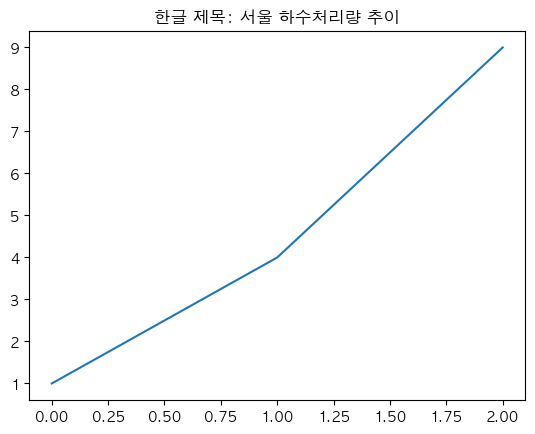

In [6]:
import matplotlib.pyplot as plt
print("현재 폰트:", plt.rcParams.get("font.family"))

# 한글이 실제로 그려지는지 테스트
plt.figure()
plt.title("한글 제목: 서울 하수처리량 추이")
plt.plot([0,1,2],[1,4,9])
plt.show()
